In [1]:
import os
import shutil
import uuid
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import image, masking
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm import expression_to_contrast_vector,second_level
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nilearn import plotting
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


This notebook covers the RT modeling sequence for the ABCD Study [Casey et al. 2018](www.doi.org/10.1016/j.dcn.2018.03.001) `Year2` MID task data. The RT framework is based on the theortical paradox described and simulated in [Mumford et al. 2023](www.doi.org/10.1038/s41562-023-01760-0) and previously demonstrated in n = 120/50 3-back working memory task and in n = 26 decision-making task [Yarkoni et al. 2009](www.doi.org/10.1371/journal.pone.0004257). 

In the current modeling of the MID task, consistent with prior litearture, we model the Anticipatory Cue and Feedback conditions. The Anticipatory model is defined as the onset and duration (2000ms) of the Cue stimulus (Loss/gain $5 or $0.20 and Neutral) and associated hit/miss feedback trails for each trial type (Loss/gain $5 or $0.20 and Neutral).

- `Section 1`. Defined Functions & setting of primary paths
- `Section 2`. Conversion of t-statistic group map images to cohen's D maps.
- `Section 3`. Calculating mRTs to use in group model + extract R/L Nacc [weighted Fixed Eff](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L189C42-L191C88) and conditions RTs. 
- `Section 4`. Plotting group maps: Cohen's D for contrasts for RT and non-RT model, estimate difference between RT and non-RT maps, and probe mean ('int') and RT ('rt') group estimate.
- `Section 5`. Example design matrix for RT model using ABCD behavioral data. Providing associated design image and contrast matrix.
- `Section 6`. Basic Scanner and demographics info for sample in analyses.


Several contrasts are modeled in the analyses as defined in the ABCD behavioral data:

- `Anticipation` - 'LRew-Neut': 'LgReward - Triangle',
- `Anticipation` - 'ARew-Neut': 'LgReward + SmallReward - 2*Triangle',
- `Anticipation` - 'LPun-Neut': 'LgPun - Triangle',
- `Anticipation` - 'APun-Neut': 'LgPun + SmallPun - 2*Triangle',
- `Feedback` - 'ARewHit-ARewMiss': 'LgReward_hit + SmallReward_hit - LgReward_miss - SmallReward_miss',
- `Feedback` - 'LRewHit-LRewMiss': 'LgReward_hit - LgReward_miss',
- `Feedback` - 'APunHit-APunMiss': 'LgPun_hit + SmallPun_hit - LgPun_miss - SmallPun_miss',
- `Feedback` - 'LPunHit-LPunMiss': 'LgPun_hit - LgPun_miss',
- `Feedback` - 'LRewHit-NeutHit': 'LgReward_hit - Triangle_hit',
- `Probe Resp.` - 'probe-base': 'probe',
- `Probe Resp.` - 'rt-base': 'probe_rt'


# 1. Functions + Path Spec

In [2]:
def nifti_tstat_to_cohensd(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    d_img_path = tstat_path.replace('tstat', 'cohensd')
    
    if not os.path.exists(d_img_path):
        t_img = nib.load(tstat_path)
        # Get data array from the t-statistics image
        t_data = t_img.get_fdata()
        # Calculate Cohen's d using the t_stat / sqrt(n) formula
        d_data = t_data / np.sqrt(n)
        # Create a NIfTI image containing Cohen's d, with the same properties as the input image
        cohensd_img = image.new_img_like(t_img, d_data)
        cohensd_img.to_filename(d_img_path)
        end_img = f"Cohen's d img created: {d_img_path}"
    else:
        end_img = f"Cohen's d img exists: {d_img_path}"
        
    return print(end_img)
    

def nifti_tstat_to_cohensd_tfce(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    d_img_path = tstat_path.replace('tstat', 'cohensd')
    tfce_path = tstat_path.replace('randomise_tstat1','randomise_tfce_corrp_fstat1') #fstat for two-sided test instead of 1-sided

    if not os.path.exists(d_img_path):
        # mask tstat image by binned >.95 tfce image
        tfce_95 = image.threshold_img(img=tfce_path, threshold=.95)
        tfce_95bin = image.math_img("img > 0", img=tfce_95)
        tstat95_img = image.math_img("img1 * img2", img1=tstat_path, img2=tfce_95bin)
        # create cohen's d map
        t_data = tstat95_img.get_fdata()
        d_data = t_data / np.sqrt(n)
        # Create a NIfTI image containing Cohen's d, with the same properties as the input image
        cohensd_img = image.new_img_like(tstat95_img, d_data)
        cohensd_img.to_filename(d_img_path)
        end_img = f"Cohen's d img created: {d_img_path}"
    else:
        end_img = f"Cohen's d img exists: {d_img_path}"
        
    return print(end_img)

                 
def nifti_tstat_to_rcoeff(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Pearson's r.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating estimate, Integer
    :return: NIfTI image containing Pearson's r.
    """
    r_img_path = tstat_path.replace('tstat', 'pearsonr')
    
    if not os.path.exists(r_img_path):
        t_img = nib.load(tstat_path)
        # Get data array from the t-statistics image
        t_data = t_img.get_fdata()
        # Calculate r's d using https://www.peggykern.org/uploads/5/6/6/7/56678211/ttestformulas.pdf
        r_data = t_data / np.sqrt(n - 2 + t_data**2)
        # Create a NIfTI image containing r, with the same properties as the input image
        r_img = image.new_img_like(t_img, r_data)
        r_img.to_filename(r_img_path)
        end_img = f"Pearson's r img created: {r_img_path}"
    else:
        end_img = f"Pearson's r exists: {r_img_path}"
        
    return print(end_img)

def nifti_tstat_to_rcoeff_tfce(tstat_path, n):
    """
    function converts NIfTI t-statistic image to Cohen's d.

    :param tstat_img: NIfTI image containing t-statistics, Nifti1Image.
    :param n: Sample size for calculating Cohen's d, Integer
    :return: NIfTI image containing Cohen's d.
    """
    r_img_path = tstat_path.replace('tstat', 'pearsonr')
    tfce_path = tstat_path.replace('randomise_tstat1','randomise_tfce_corrp_fstat1') #fstat for two-sided test instead of 1-sided

    if not os.path.exists(r_img_path):
        # mask tstat image by binned >.95 tfce image
        tfce_95 = image.threshold_img(img=tfce_path, threshold=.95)
        tfce_95bin = image.math_img("img > 0", img=tfce_95)
        tstat95_img = image.math_img("img1 * img2", img1=tstat_path, img2=tfce_95bin)
        # create cohen's d map
        t_data = tstat95_img.get_fdata()
        r_data = t_data / np.sqrt(n - 2 + t_data**2)
        # Create a NIfTI image containing r, with the same properties as the input image
        r_img = image.new_img_like(tstat95_img, r_data)
        r_img.to_filename(r_img_path)
        end_img = f"Pearson's r img created: {r_img_path}"
    else:
        end_img = f"Pearson's r exists: {r_img_path}"
        
    return print(end_img)


def imgs_intersect(img1_path, img2_path):
    img1 = nib.load(img1_path)
    img2 = nib.load(img2_path)

    img1_dat = img1.get_fdata()
    img2_dat = img2.get_fdata()
    assert (img1.affine == img2.affine).all(), "Affine matrices of the images do not match."
    
    img1_mask = img1_dat != 0
    img2_mask = img2_dat != 0

    intersection_mask = np.logical_and(img1_mask, img2_mask)
    img1_intersect = img1_dat * intersection_mask
    img2_intersect = img2_dat * intersection_mask
    return img1_intersect, img2_intersect
    
def diff_intersect_imgs(non_mod_img, rt_mod_img):
    
    img1_intersect, img2_intersect = imgs_intersect(img1_path=non_mod_img, 
                                                    img2_path=rt_mod_img)
    diff_img = img1_intersect - img2_intersect
    affine_img1 = nib.load(non_mod_img)
    
    return nib.Nifti1Image(diff_img, affine_img1.affine, affine_img1.header)

def create_hitmiss(events_df: pd.DataFrame, hit_col: str, condition_col: str) -> pd.DataFrame:

    # create a delinated hit v miss column so it is more clear
    feedback_hitmiss_lab = 'Feedback.Response'
    events_df[feedback_hitmiss_lab] = np.where(events_df[hit_col] == 1.0,
                                               events_df[condition_col] + '_hit',
                                               events_df[condition_col] + '_miss')
    return events_df

def calc_mask_avg(img, mask):
    masked_data = masking.apply_mask(image.load_img(img), mask)
    return np.round(np.mean(masked_data), 3)

def pseudo_id(data: pd.DataFrame, column_name: str):
    unique_subjects = data[column_name].unique()
    id_mapping = {subject: str(uuid.uuid4()) for subject in unique_subjects}
    data[column_name] = data[column_name].map(id_mapping)
    return data

In [3]:
session = 'ses-2YearFollowUpYArm1'
out_path = '/scratch.global/mdemiden/mid_rt_mod'
grpmap_path = f'{out_path}/group/{session}/session'
fix_path = f'{out_path}/firstlvl/{session}'
beh_path = '/home/feczk001/mdemiden/slurm_ABCD_s3/Beh_Data/events_to_tsv/2YearFollowUpYArm1_MID'
script_path='/home/feczk001/mdemiden/analyses/mid_rt_bold/scripts'
nda_info_file = '/home/feczk001/mdemiden/analyses/nda2yr_sub_details.tsv'
sub_list = f'{script_path}/cluster_jobs/subject_ids/ids_sub_2yr.tsv'
left_nac = f'{script_path}/brain_mask/Left_NAcc.nii.gz'
right_nac = f'{script_path}/brain_mask/Right_NAcc.nii.gz'

# 2. Convert t-maps to d-maps

In [ ]:
# Nilearn out
t_list_means = glob(os.path.join(grpmap_path,"subs-*_stat-tstat_int.nii.gz"))
for t_path in t_list_means:
    sub_n = os.path.basename(t_path).split('_')[0].split('-')[1]
    nifti_tstat_to_cohensd(tstat_path=t_path, n=int(sub_n))

t_list_corrs = glob(os.path.join(grpmap_path,"subs-*_stat-tstat_rt.nii.gz"))
for t_path in t_list_corrs:
    sub_n = os.path.basename(t_path).split('_')[0].split('-')[1]
    nifti_tstat_to_rcoeff(tstat_path=t_path, n=int(sub_n))

In [ ]:
# Randomise out
t_list_means = glob(f'{grpmap_path}/randomise/randomise/**/grp/subs-*_randomise_tstat1.nii.gz')
for t_path in t_list_means:
    sub_n = os.path.basename(t_path).split('_')[0].split('-')[1]
    nifti_tstat_to_cohensd_tfce(tstat_path=t_path, n=int(sub_n))


t_list_corrs = glob(f'{grpmap_path}/randomise/randomise/**/rt/subs-*_randomise_tstat1.nii.gz')
for t_path in t_list_corrs:
    sub_n = os.path.basename(t_path).split('_')[0].split('-')[1]
    nifti_tstat_to_rcoeff_tfce(tstat_path=t_path, n=int(sub_n))

In [ ]:
# Randomise out diff maps
t_list_means = glob(f'{grpmap_path}/randomise/randomise/**/grp/diff/subs-*_randomise_tstat1.nii.gz')
for t_path in t_list_means:
    sub_n = os.path.basename(t_path).split('_')[0].split('-')[1]
    nifti_tstat_to_cohensd_tfce(tstat_path=t_path, n=int(sub_n))

# 3. Calculate RT values

## 3.1 Calculate avg RT values for group estimates

Calculate RT values for each subjects (average across runs within each subject). Taking mean OverallRT within run per subject and then average the two for each subject for a single value per session. These are used in the group map estimation.

Specifically, two separate models are fit:
- mod-Cue-None: First Levl GLM include the 5 Anticipation, 10 Feedback, 4 Cosine Cosine (fMRIPrep estimated), 12 motion regressors (xyz+derivatives). The design matrix is specified in the github [here](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L123-L134)
- mod-Cue-RT: First Levl GLM include the 5 Anticipation, 10 Feedback, 1 probe, 1 response time, 4 Cosine Cosine (fMRIPrep estimated), 12 motion regressors (xyz+derivatives). The design matrix is specified in the github [here](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L97-L112)

Across the anticipory and feedback contrasts decribed above. The group maps estimate a [mean map ('int') and association with the mRT (rt)](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/group_estimate.py#L35-L53).

In [17]:
out_rts = []

sub_df = pd.read_csv(sub_list, sep='\t',header=None)
for sub in sub_df[0]:    
    run1 = f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-01_events.tsv'
    run1_df = pd.read_csv(run1, sep='\t')
    avg_rt1 = round(run1_df['OverallRT'].mean(),3)
    
    run2 = f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-02_events.tsv'
    run2_df = pd.read_csv(run2, sep='\t')
    avg_rt2 = round(run2_df['OverallRT'].mean(),3)

    avg_rts = round(np.mean([avg_rt1,avg_rt2]),3)
    out_rts.append({'Subject': sub, 'Average_RT': avg_rts})
    
out_rts_df = pd.DataFrame(out_rts)
out_rts_df.to_csv(f'{out_path}/subs_avg-overall-rts.csv', index=False)

## 3.2 Run Avg Betas + Conditional RTs

### 3.2.1 NAc Harvard Oxford Mask

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


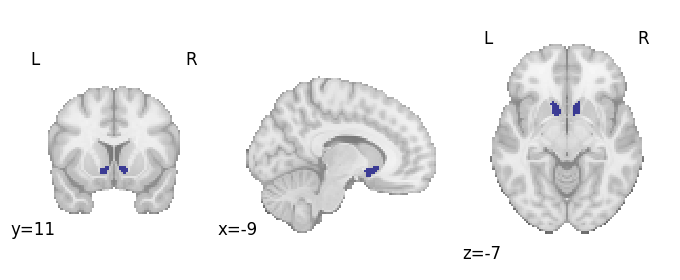

In [5]:
left_nac_img = image.load_img(left_nac)
right_nac_img = image.load_img(right_nac)
combined_mask = np.logical_or(left_nac_img.get_fdata(), right_nac_img.get_fdata())
combined_mask_img = image.new_img_like(left_nac_img, combined_mask)
plotting.plot_roi(combined_mask_img, title='',draw_cross=False)
plotting.show()

### 3.2.2 Extract estimates and calculate RTs

In [29]:
fb_contrasts = {
    'ARewHit-ARewMiss': ['LgReward_hit','SmallReward_hit','LgReward_miss','SmallReward_miss'],
    'LRewHit-LRewMiss': ['LgReward_hit','LgReward_miss'], 
    'APunHit-APunMiss': ['LgPun_hit','SmallPun_hit','LgPun_miss','SmallPun_miss'],
    'LPunHit-LPunMiss': ['LgPun_hit','LgPun_miss'], 
    'LRewHit-NeutHit': ['LgReward_hit', 'Triangle_hit']
}

In [56]:
sub_ids = []
label_list = []
left_rt_mod_list = []
right_rt_mod_list = []
left_non_rt_list = []
right_non_rt_list = []
r1_avg_a_list = []
r2_avg_a_list = []
r1_avg_b_list = []
r2_avg_b_list = []

ran_fixeff_dirs = [d for d in os.listdir(fix_path) if os.path.isdir(os.path.join(fix_path, d)) and d.startswith('sub-')]

for sub in ran_fixeff_dirs:
    # create hit/miss feedback consistent with first lvl models
    r1_df = pd.read_csv(f'{beh_path}/{sub}_{session}_task-MID_run-01_events.tsv', sep='\t')
    r2_df = pd.read_csv(f'{beh_path}/{sub}_{session}_task-MID_run-02_events.tsv', sep='\t')
    r1_df = create_hitmiss(r1_df, 'prbacc','Condition')
    r2_df = create_hitmiss(r2_df, 'prbacc','Condition')

    # iterate over contrsat label + Feedback.Response elements to calcualte RTs & extra run avg beta weights 
    for label, contrast  in fb_contrasts.items():
        cue_rt_img = f'{fix_path}/{sub}/{sub}_{session}_task-MID_contrast-{label}_mod-Cue-rt_stat-effect.nii.gz'
        cue_none_img = f'{fix_path}/{sub}/{sub}_{session}_task-MID_contrast-{label}_mod-Cue-None_stat-effect.nii.gz'
        rtmod_leftnac = calc_mask_avg(cue_rt_img, left_nac)
        rtmod_rightnac = calc_mask_avg(cue_rt_img, right_nac)
        nort_leftnac = calc_mask_avg(cue_none_img, left_nac)
        nort_rightnac = calc_mask_avg(cue_none_img, right_nac)

        # constrain Feedback cues to elements used in contrast
        filt_r1 = r1_df[r1_df['Feedback.Response'].isin(contrast)].dropna(subset=['OverallRT'])
        filt_r2 = r2_df[r2_df['Feedback.Response'].isin(contrast)].dropna(subset=['OverallRT'])

        # Lg+small hit + Lg + small miss = four elements, otherwise feedback has 2 elements (e.g. lg hit > lg miss)
        if len(contrast) > 2:
            # hit mRTs 
            r1_avg_a = filt_r1[filt_r1['Feedback.Response'].str.endswith('_hit')]['OverallRT'].mean()
            r2_avg_a = filt_r2[filt_r2['Feedback.Response'].str.endswith('_hit')]['OverallRT'].mean()
            # miss mRTs
            r1_avg_b = filt_r1[filt_r1['Feedback.Response'].str.endswith('_miss')]['OverallRT'].mean()
            r2_avg_b = filt_r2[filt_r2['Feedback.Response'].str.endswith('_miss')]['OverallRT'].mean()
            
        elif len(contrast) <= 2:
            r1_avg_a = filt_r1[filt_r1['Feedback.Response'] == contrast[0]]['OverallRT'].mean()
            r2_avg_a = filt_r2[filt_r2['Feedback.Response'] == contrast[0]]['OverallRT'].mean()

            r1_avg_b = filt_r1[filt_r1['Feedback.Response'] == contrast[1]]['OverallRT'].mean()
            r2_avg_b = filt_r2[filt_r2['Feedback.Response'] == contrast[1]]['OverallRT'].mean()

        # Append to lists
        sub_ids.append(sub)
        label_list.append(label)
        left_rt_mod_list.append(rtmod_leftnac)
        right_rt_mod_list.append(rtmod_rightnac)
        left_non_rt_list.append(nort_leftnac)
        right_non_rt_list.append(nort_rightnac)
        r1_avg_a_list.append(r1_avg_a)
        r2_avg_a_list.append(r2_avg_a)
        r1_avg_b_list.append(r1_avg_b)
        r2_avg_b_list.append(r2_avg_b)

In [112]:
comb_vars = {
    'sub': sub_ids,
    'contrast': label_list,
    'left_rt_mod': left_rt_mod_list,
    'right_rt_mod': right_rt_mod_list,
    'left_none_rt': left_non_rt_list,
    'right_none_rt': right_non_rt_list,
    'r1_avg_a': r1_avg_a_list,
    'r2_avg_a': r2_avg_a_list,
    'r1_avg_b': r1_avg_b_list,
    'r2_avg_b': r2_avg_b_list
}

betas_rts_df = pd.DataFrame(comb_vars)
betas_rts_df.to_csv(f'{out_path}/subs_betas-rts.csv', index=False)

In [191]:
betas_df = pd.read_csv(f'{out_path}/subs_betas-rts.csv', sep=',')
betas_df = pseudo_id(data=betas_df, column_name='sub')

# 4. Plotting Group maps

In [30]:
# group level contrast 
contrasts_reg = [
    # anticipatory contrasts for cue-model
    'LRew-Neut', 'ARew-Neut', 'LPun-Neut', 'APun-Neut',
    # feedback contrasts
    'ARewHit-ARewMiss', 'LRewHit-LRewMiss', 'APunHit-APunMiss',
    'LPunHit-LPunMiss', 'LRewHit-NeutHit'
]
# rt versus non-rt model
models = ['Cue-rt', 'Cue-None']
# thresh/coordinate
spec_coords = (12,8,-10)
lmotor_coords = (-42, -20, 47)
d_thresh = .2
d_max =1

## 4.1 One sample t-test: `mod-Cue-rt`, `mod-Cue-None`, `mod-Cue-probeXcond`

### 4.1.1 Cohen's D Group averages (Thresholded TFCE p < .05)

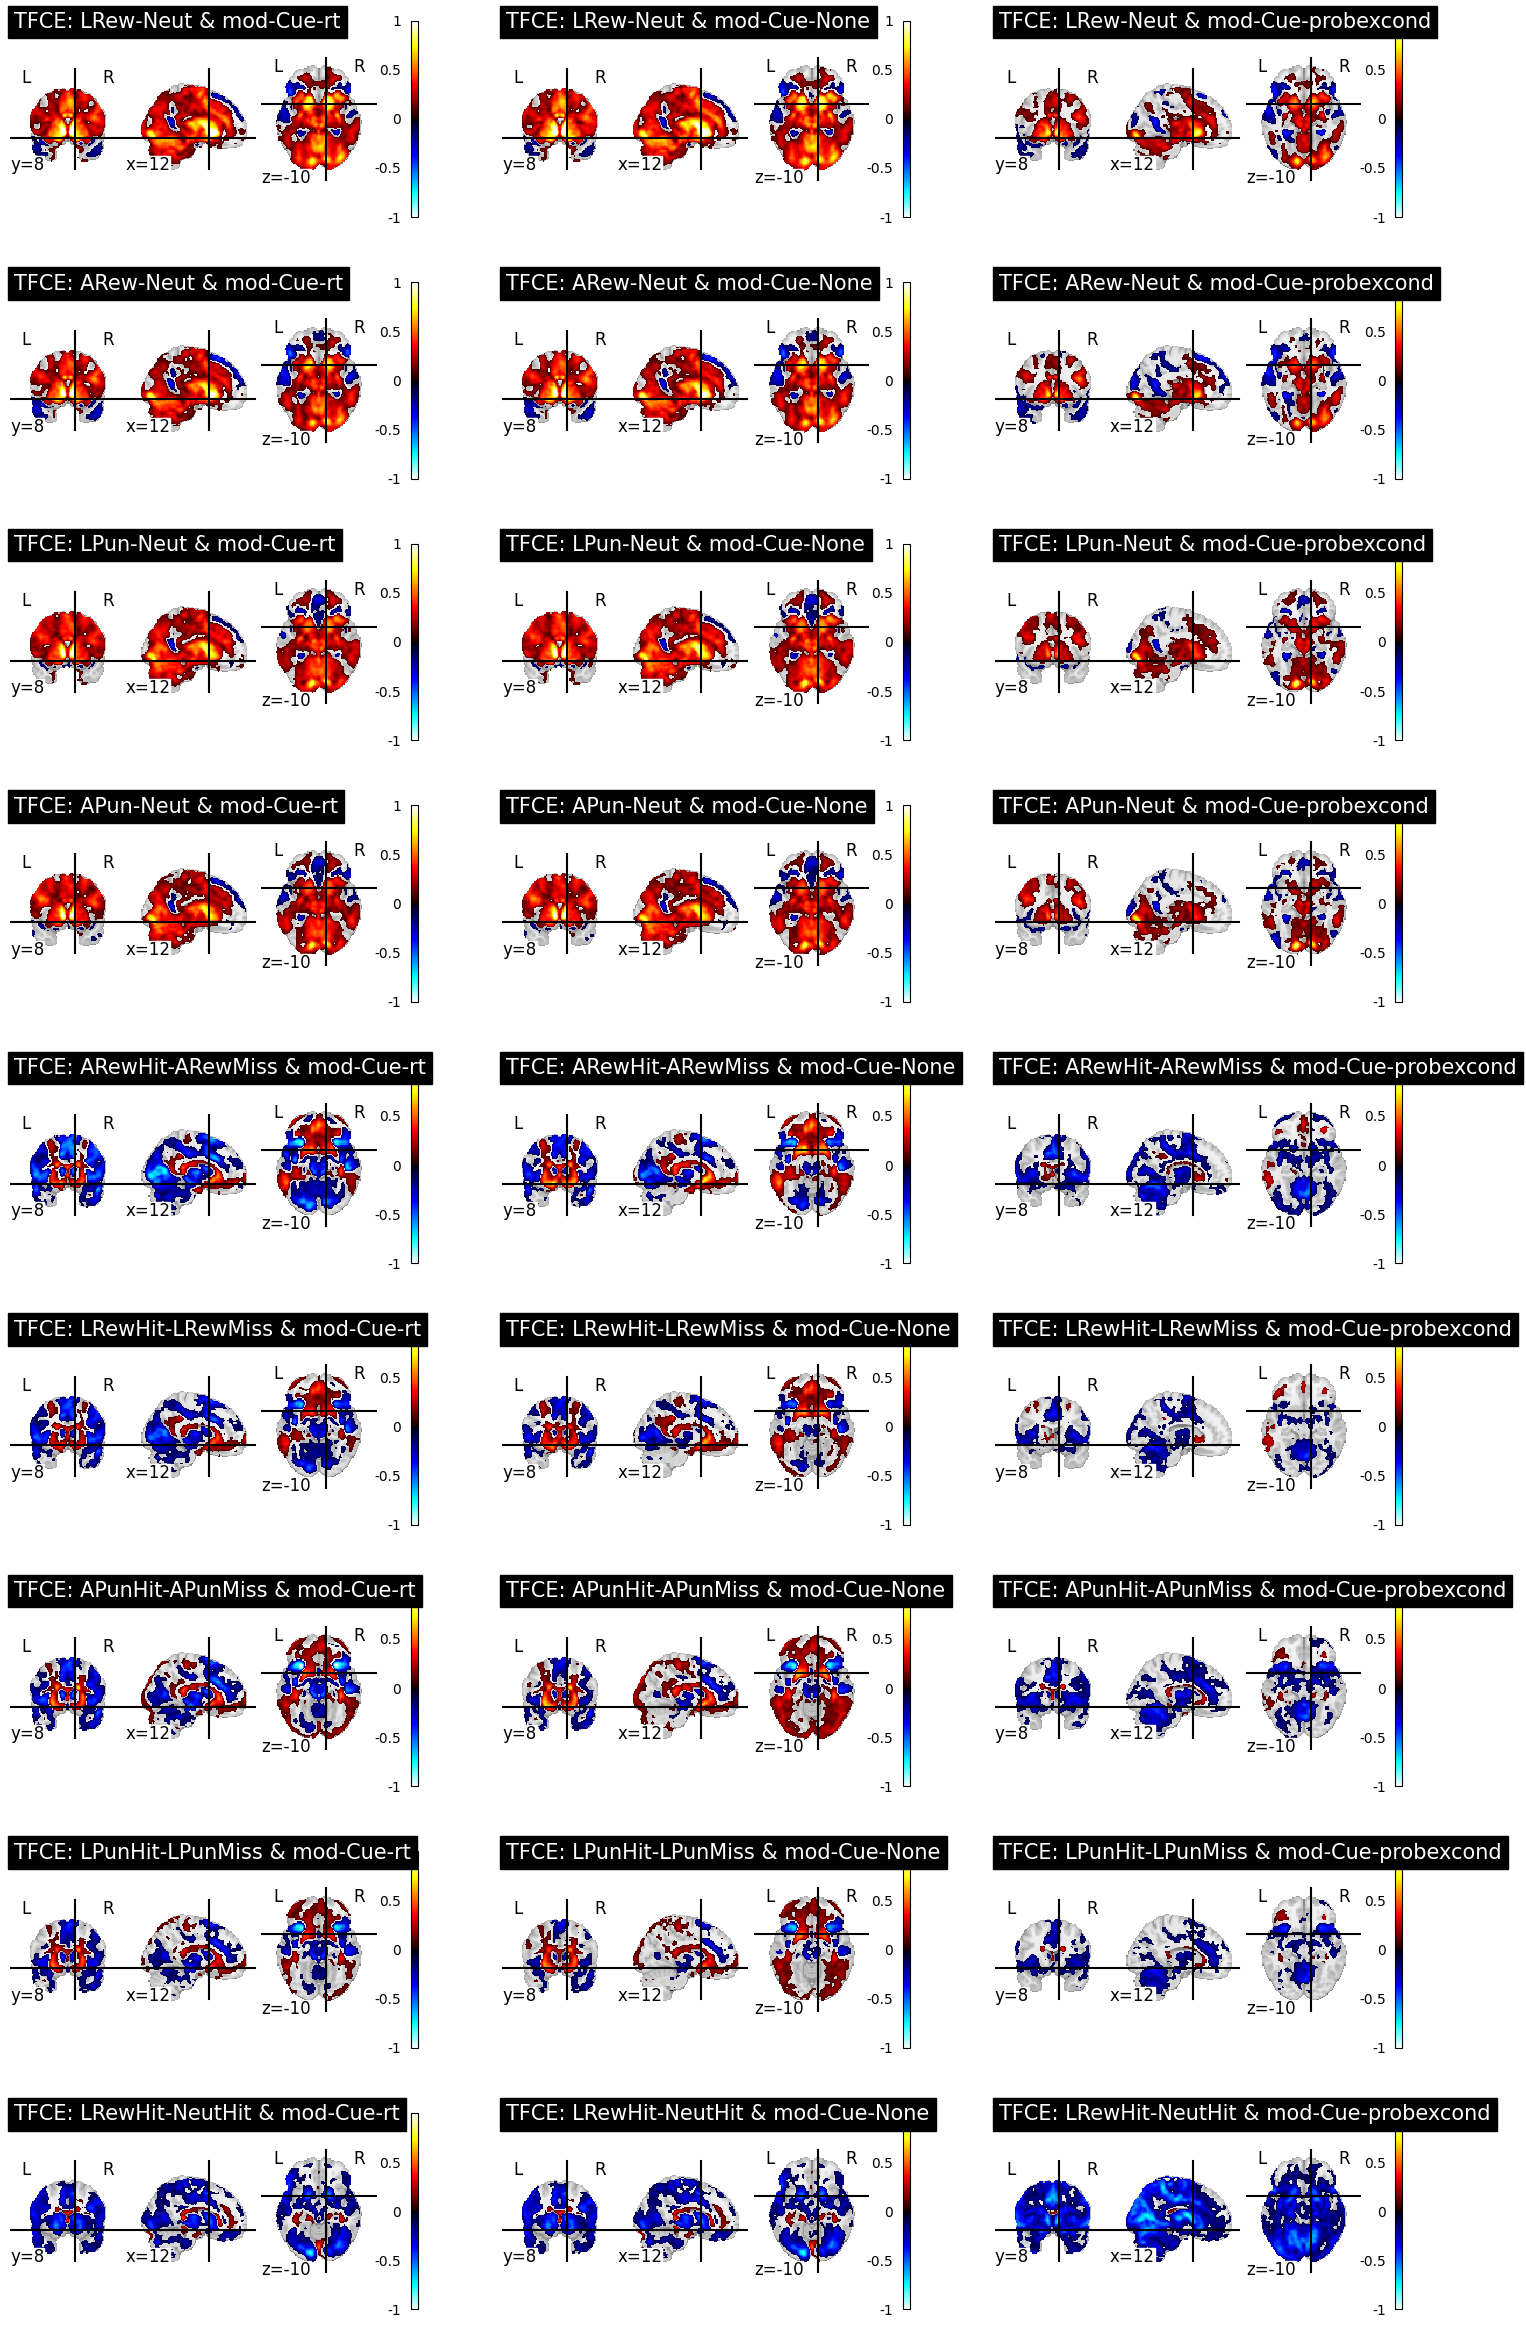

In [33]:
# randomise TFCE plots
n_cols = 3
n_rows = len(contrasts_reg)
fig, axes = plt.subplots(len(contrasts_reg), n_cols, figsize=(18,30))

for mod in ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond']:
    for i, con in enumerate(contrasts_reg):
        con_img = glob(f'{grpmap_path}/randomise/randomise/{con}/grp/subs-*_contrast-{con}_{mod}_randomise_cohensd1.nii.gz')[0]
        col = ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond'].index(mod)
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               title=f"TFCE: {con} & {mod}", draw_cross=True,
                               vmax=d_max, #threshold=d_thresh, 
                               colorbar=True, axes=axes[i, col])

plt.show()

### 4.1.2 Cohen's D Group averages (Thresh = 0.20)

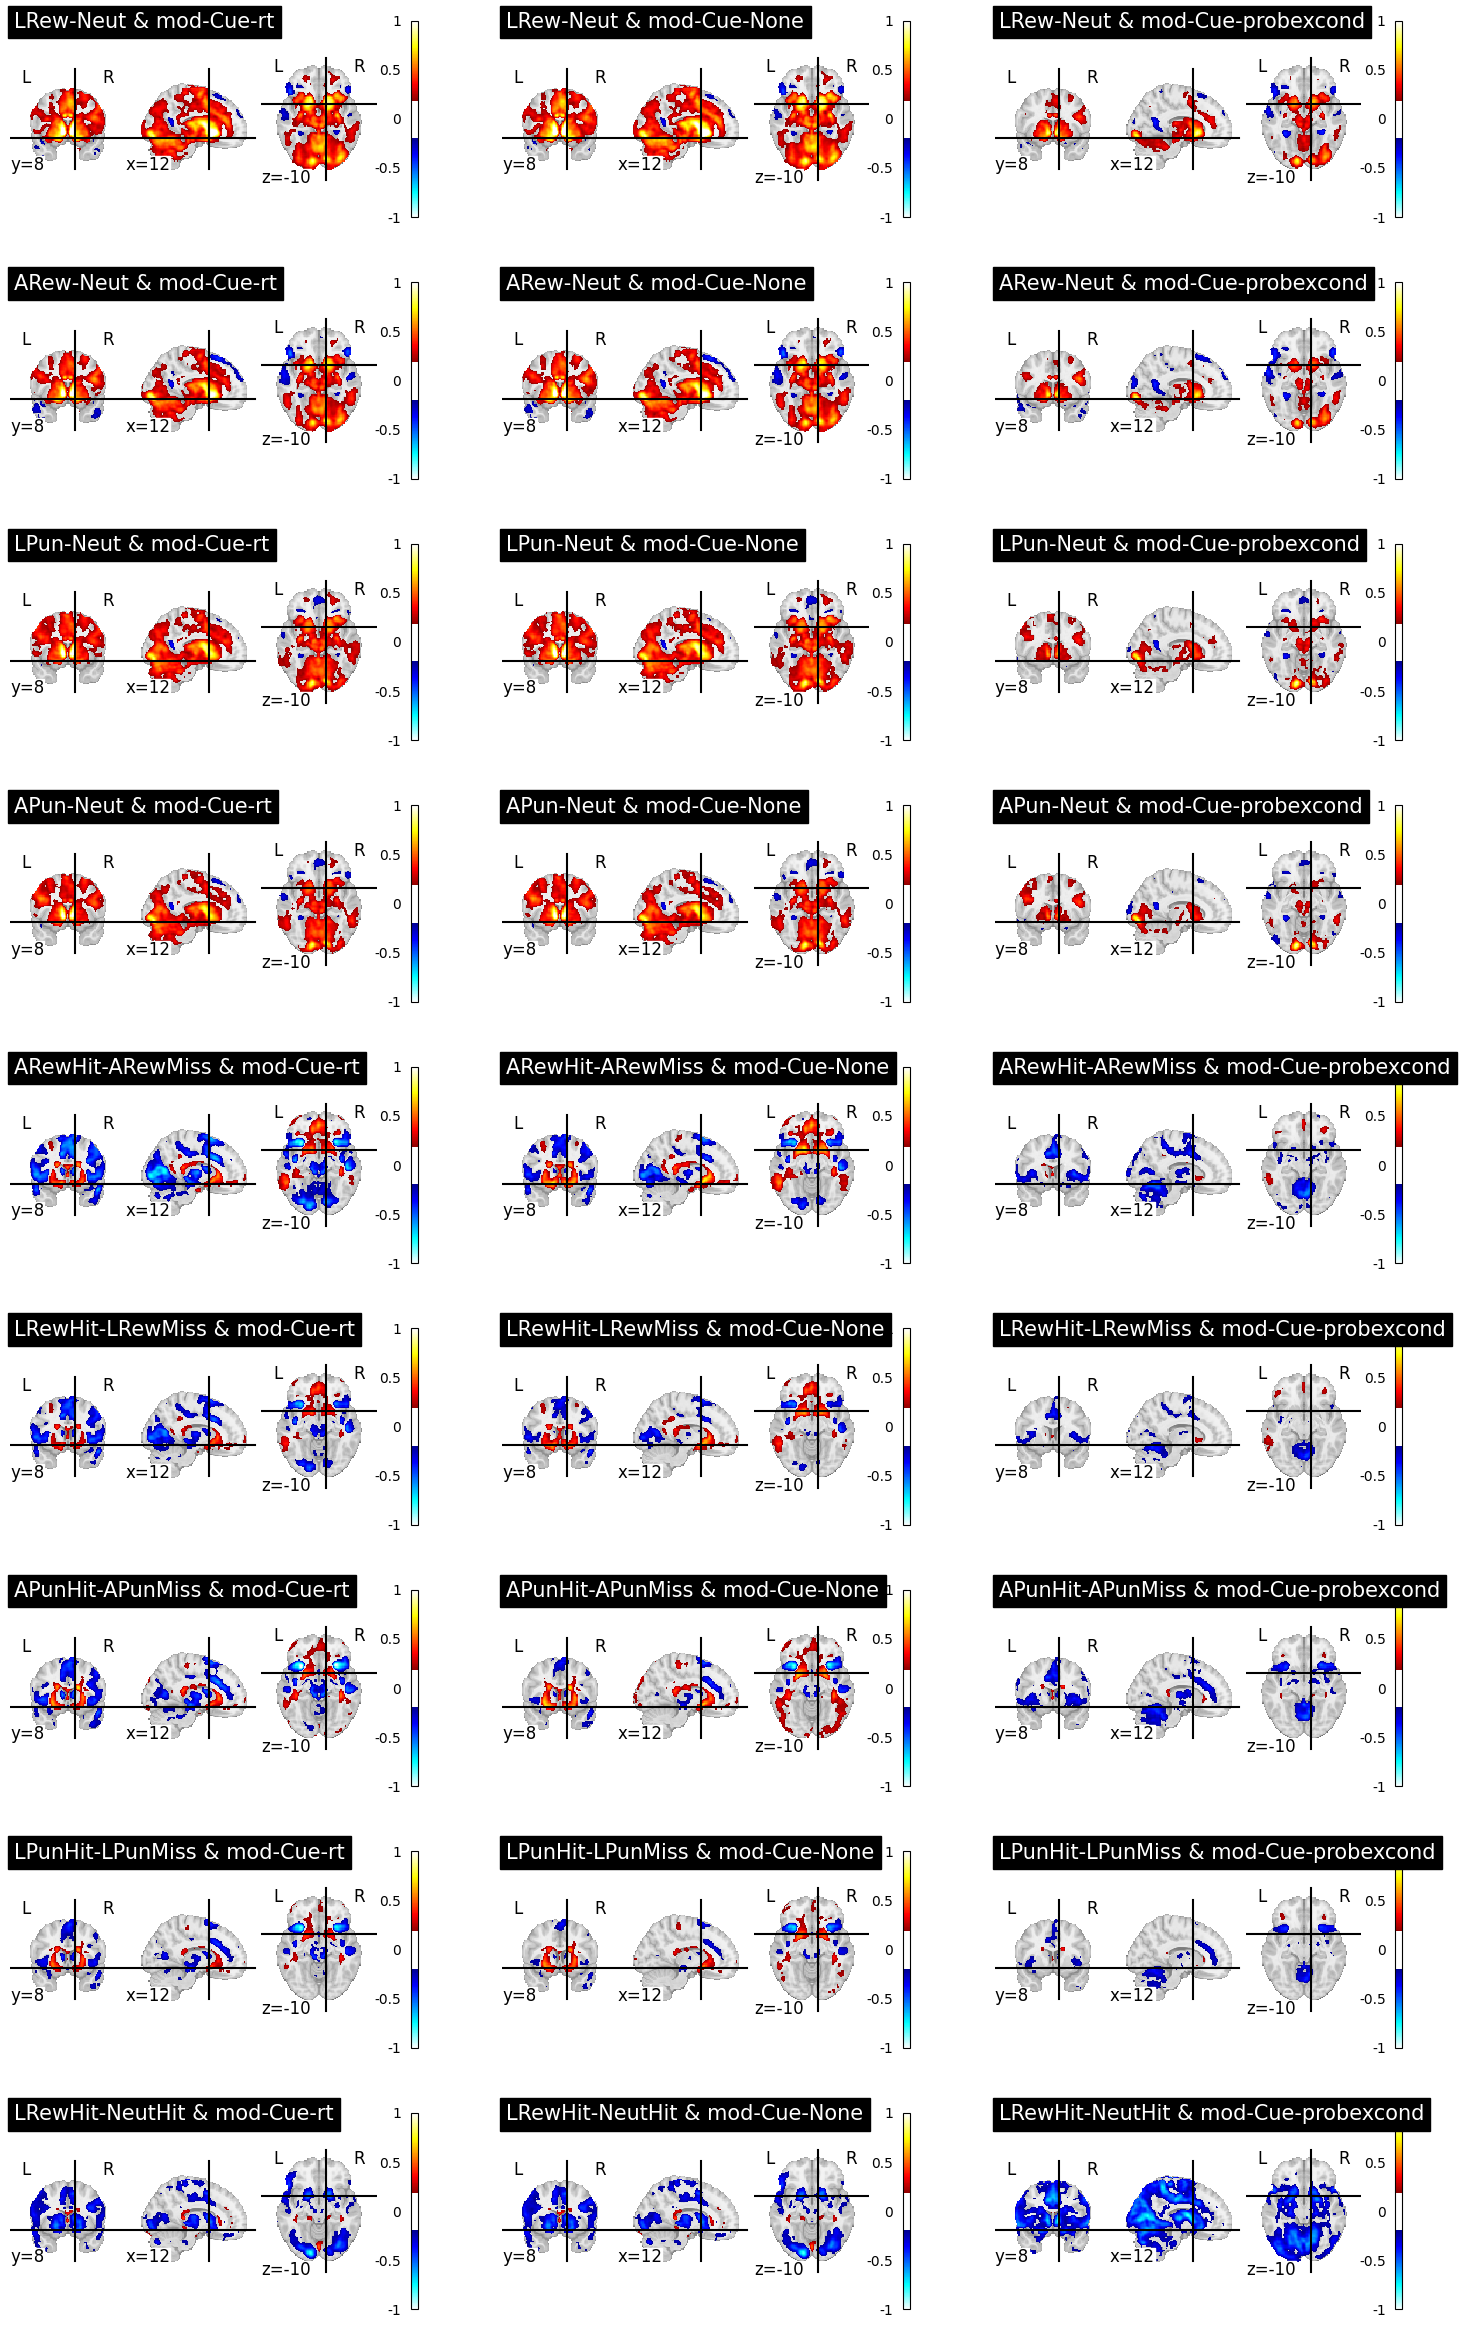

In [40]:
n_cols = 3
n_rows = len(contrasts_reg)
fig, axes = plt.subplots(len(contrasts_reg), n_cols, figsize=(18,30))

for mod in ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond']:
    for i, con in enumerate(contrasts_reg):
        con_img = glob(f'{grpmap_path}/subs-*{con}_{mod}_stat-cohensd_int.nii.gz')[0]
        col = ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond'].index(mod)
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               title=f"{con} & {mod}", threshold=d_thresh, draw_cross=True,
                               vmax=d_max, colorbar=True,
                               axes=axes[i, col])

plt.show()

## 4.2 Differences between contrast estimates:  `mod-Cue-None` - `mod-Cue-rt`

### 4.2.1 Difference in Cohen's D's (thresholded using conjunction TFCE p < .05) 

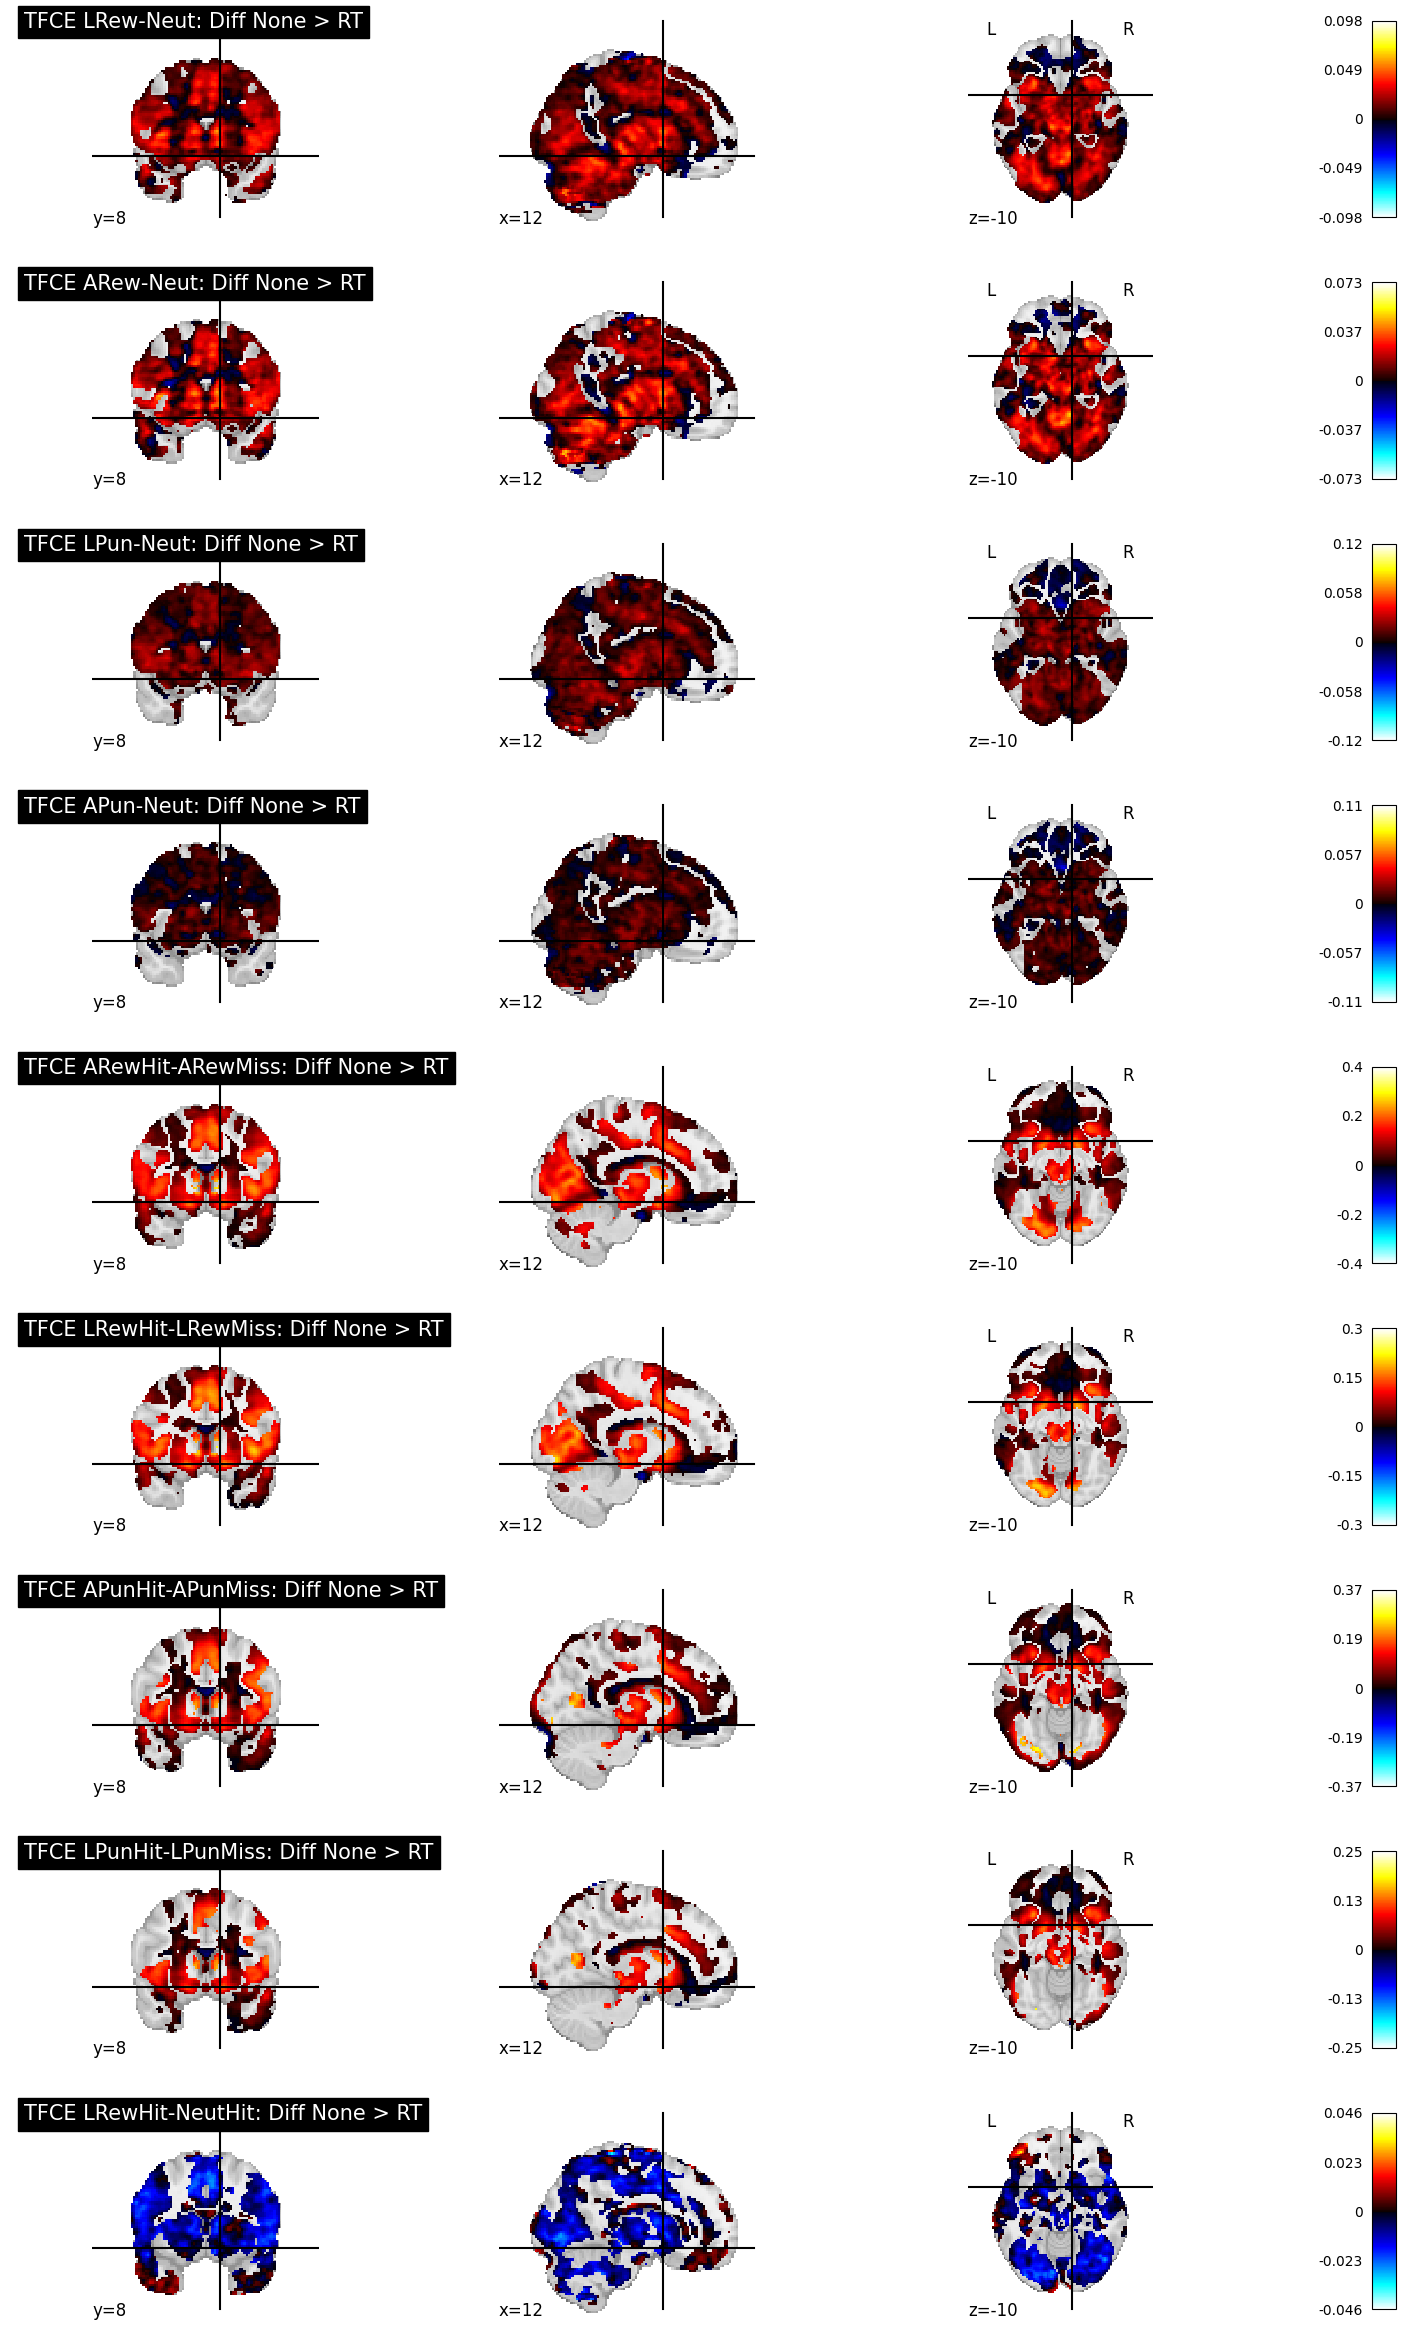

In [13]:
rt_minus_none = []
for i, con in enumerate(contrasts_reg):
    con_img_none = f'{grpmap_path}/randomise/randomise/{con}/grp/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-None_randomise_cohensd1.nii.gz'
    con_img_rt = f'{grpmap_path}/randomise/randomise/{con}/grp/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_randomise_cohensd1.nii.gz'
    difference = diff_intersect_imgs(non_mod_img=con_img_none, rt_mod_img=con_img_rt)
    rt_minus_none.append((difference, con))  # Store the difference image along with the contrast label

fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, (img, con) in enumerate(rt_minus_none):
    plotting.plot_stat_map(stat_map_img=img, cut_coords=spec_coords,
                           display_mode="ortho",
                           title=f"TFCE {con}: Diff None > RT", draw_cross=True, 
                           #vmax=.5, threshold=.1,
                           colorbar=True, axes=axes[i])

### 4.2.2 Paired T-test: `mod-Cue-None` > `mod-Cue-rt` (TFCE p < .05)

The above takes the order of operations: estimates a group average maps for each contrast (TFCE, permutations = 1000) for the Cue-None and Cue-RT models (e.g. Cue-None minus Cue-RT), and then takes the difference for the TFCE p < .05 voxels in the Cohen's d maps. 

The below takes the difference at the run avg map for each subject. Specifically, the difference between the Cue-None and Cue-RT models (e.g. Cue-None minus Cue-RT) for the effect maps from the weighted fixed effects. Then, this difference map is used in randomise (TFCE, permutations = 1000) to estimate the voxels that are significantly different from the [Cue-None - Cue-RT] fixed effect estimates. The significant voxels (TFCE < .05) are then plotted for the Cohen's d map.

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


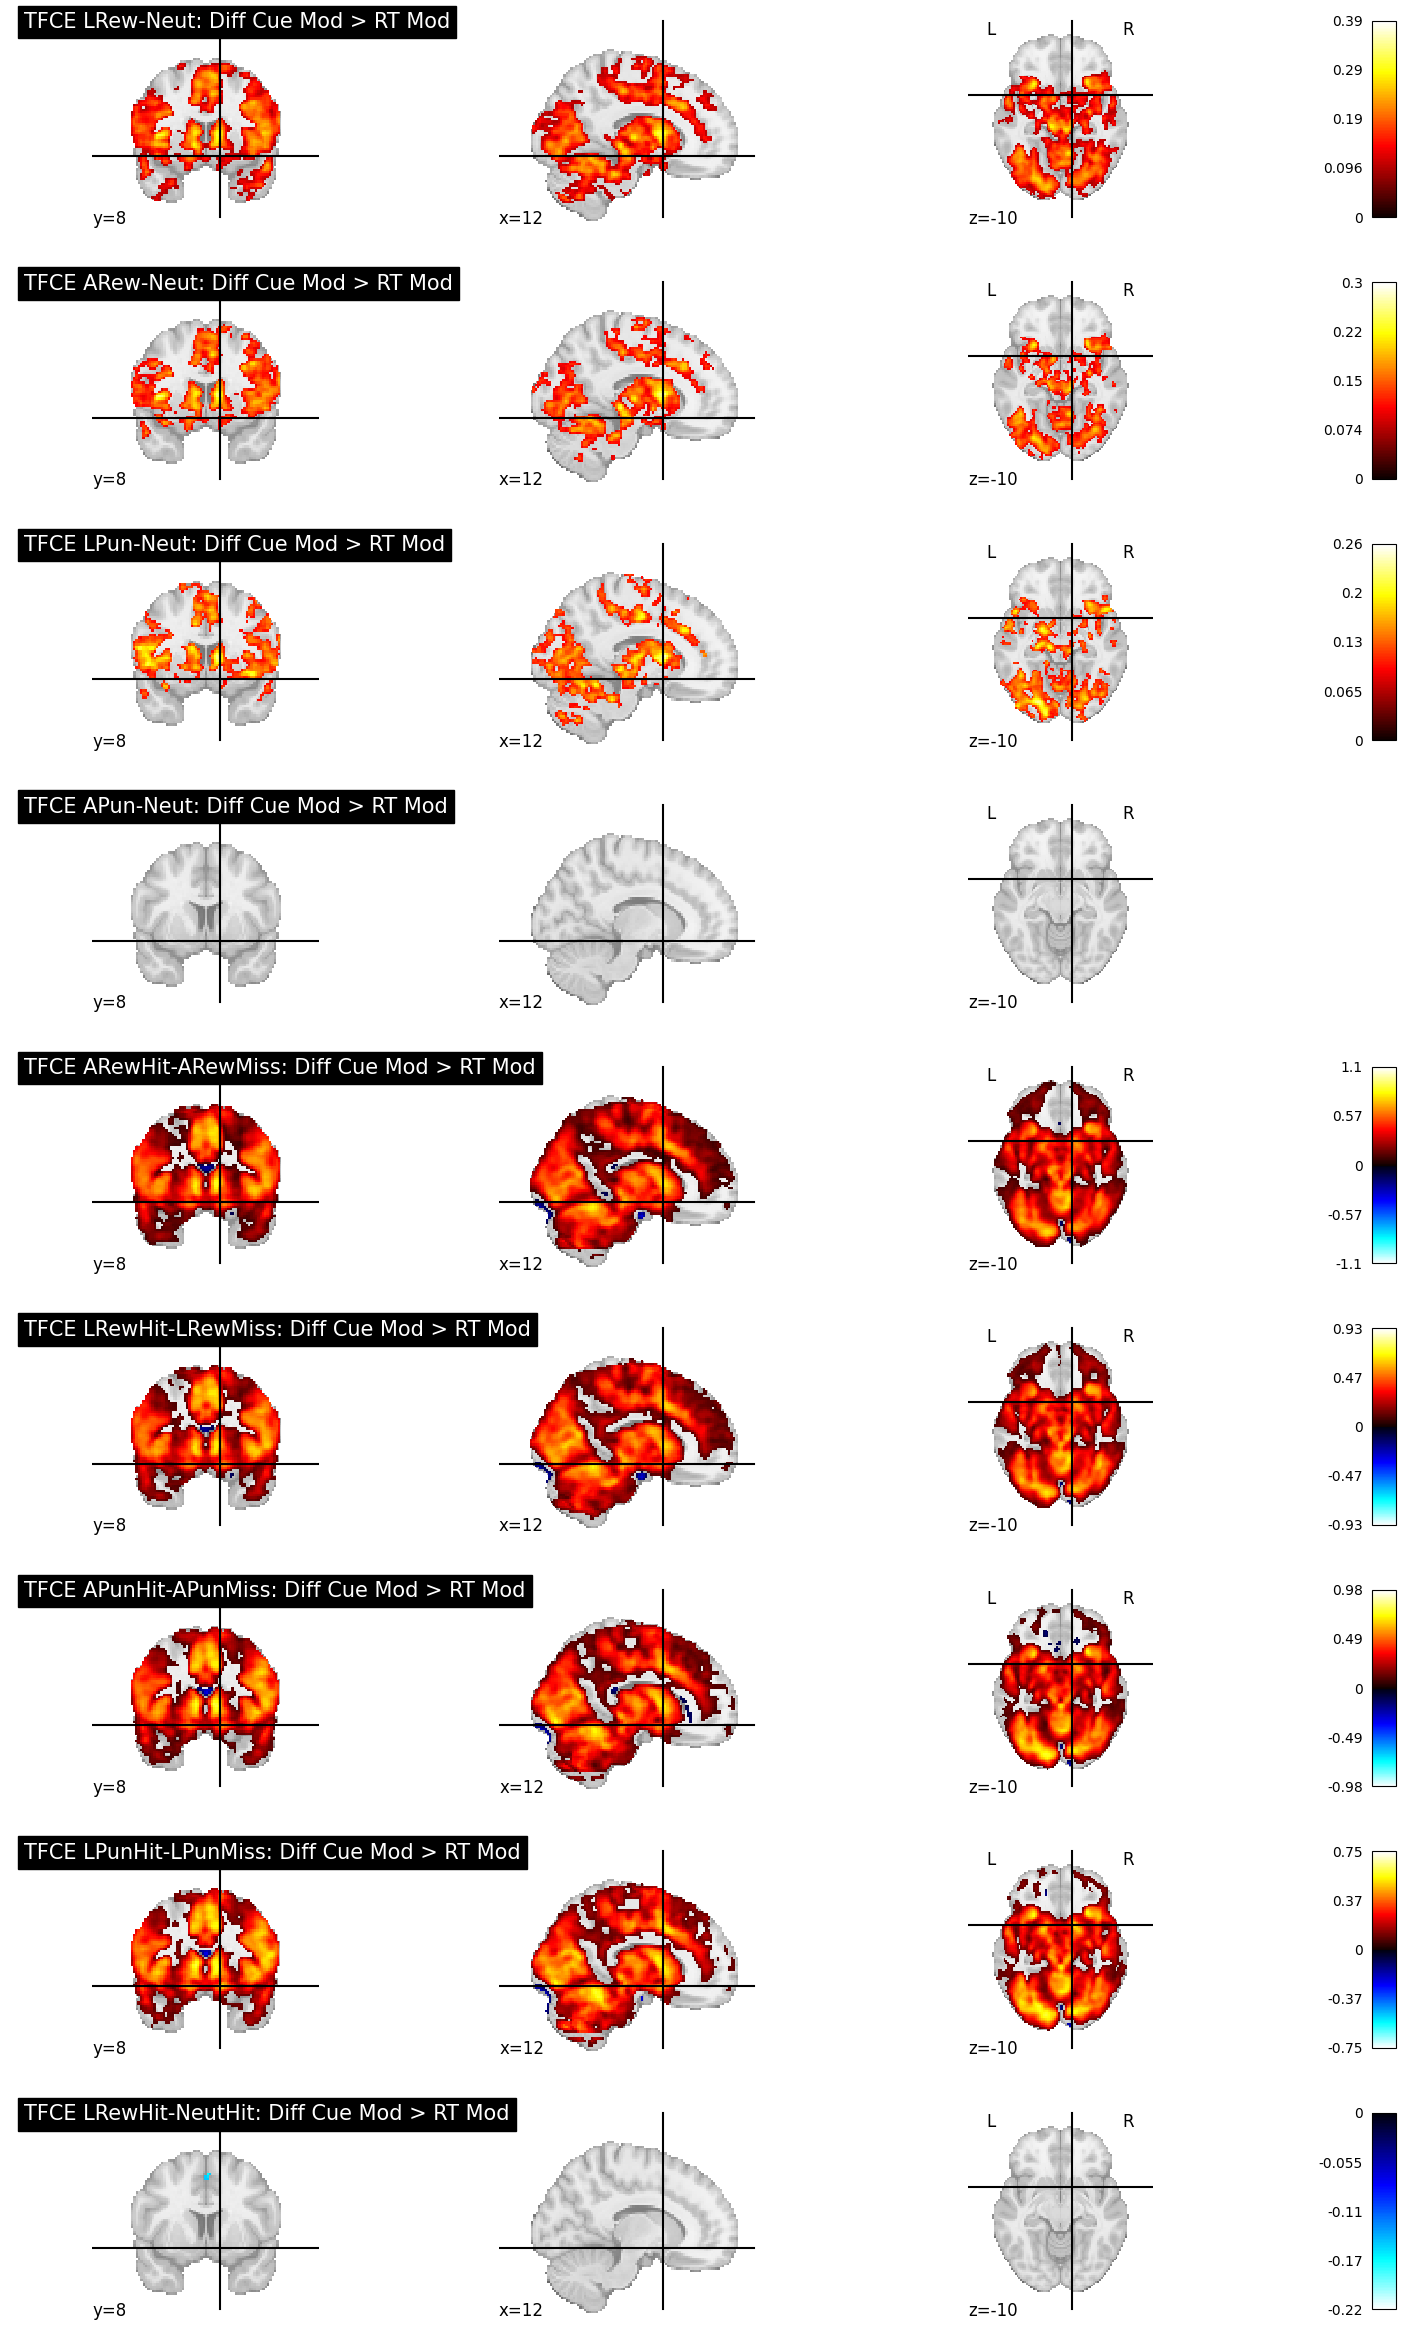

In [14]:
fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, con in enumerate(contrasts_reg):
    con_img = glob(f'{grpmap_path}/randomise/randomise/{con}/grp/diff/subs-500_*_contrast-{con}_diff-cue-rt_randomise_cohensd1.nii.gz')[0]
    plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                           display_mode="ortho",
                           title=f"TFCE {con}: Diff Cue Mod > RT Mod",  
                           draw_cross=True,colorbar=True,
                           axes=axes[i])

### 4.2.3 Difference in Cohen's D group averages:  `mod-Cue-None` - `mod-Cue-rt`(thresh = 0.1)

Comparing Cohen's D values isn't the optimal comparison of the two models here as they are paired. Please refer to the paired t-test comparison above.

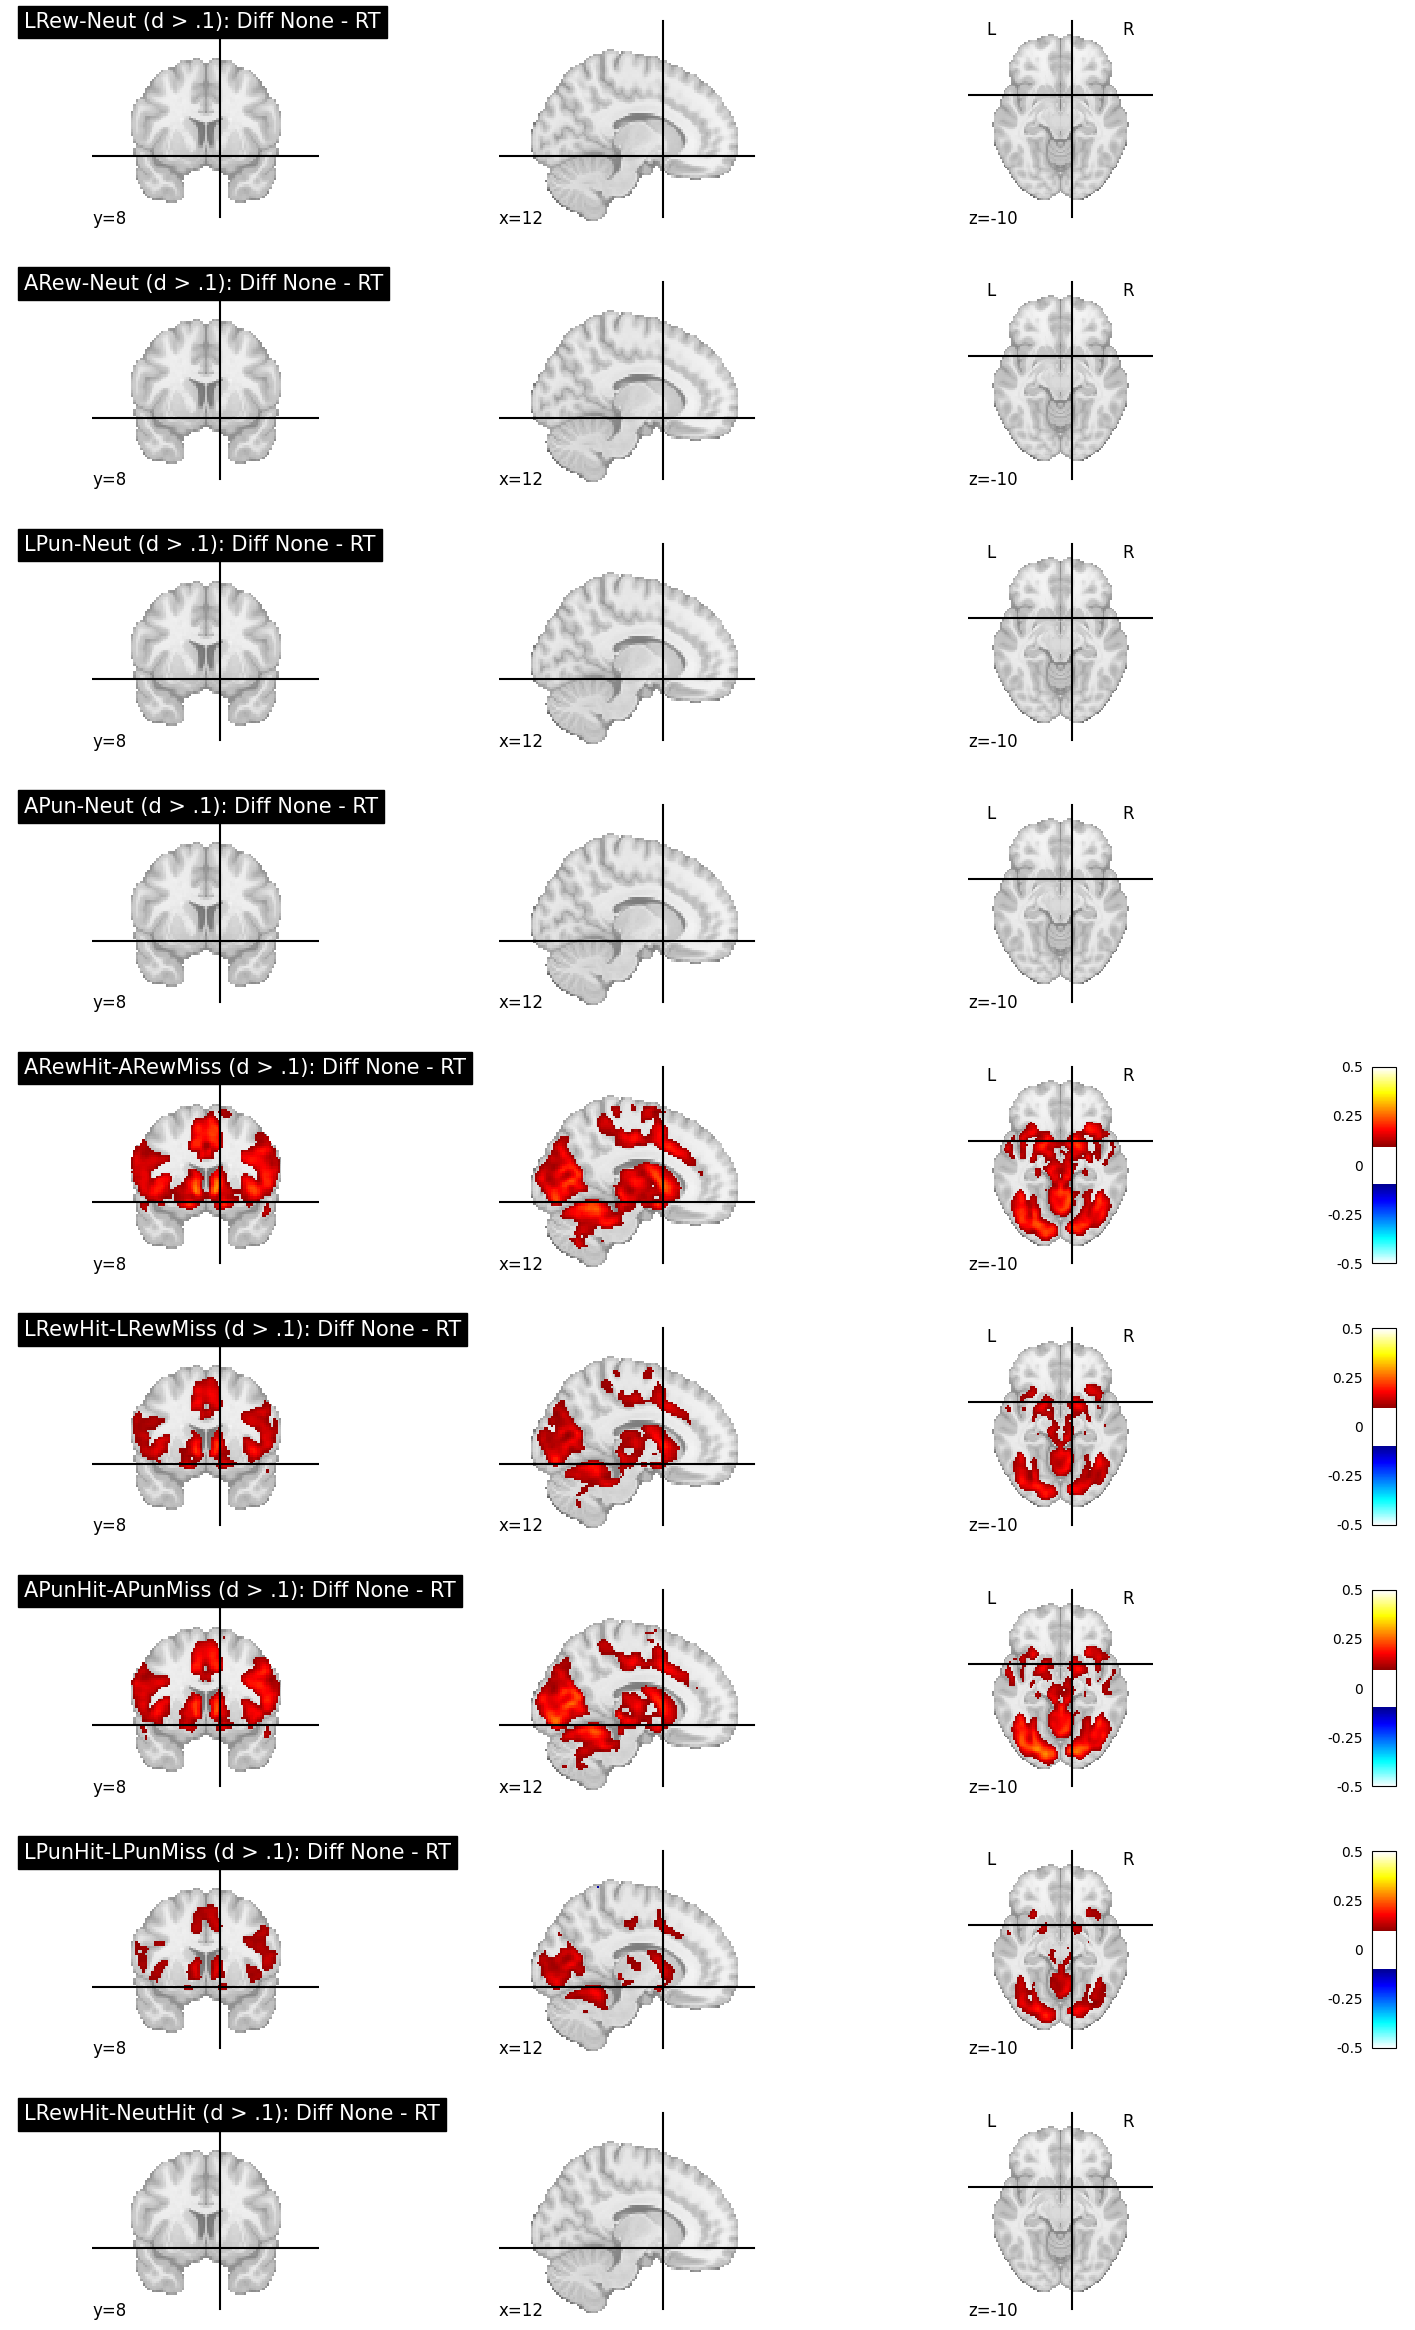

In [15]:
rt_minus_none = []
for i, con in enumerate(contrasts_reg):
    con_img_none = nib.load(f'{grpmap_path}/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-None_stat-cohensd_int.nii.gz')
    con_img_rt = nib.load(f'{grpmap_path}/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_stat-cohensd_int.nii.gz')
    difference = image.math_img('img1 - img2', img1=con_img_none, img2=con_img_rt)
    rt_minus_none.append((difference, con))  # Store the difference image along with the contrast label

fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, (img, con) in enumerate(rt_minus_none):
    plotting.plot_stat_map(stat_map_img=img, cut_coords=spec_coords,
                           display_mode="ortho",
                           title=f"{con} (d > .1): Diff None - RT", draw_cross=True,
                           vmax=.5, threshold=.1,
                           colorbar=True, axes=axes[i])

plt.show()

## 4.3 Probe Maps: int & rt for probe-base and rt-base

### 4.3.1 Avgerage and correlation with mean RT, TFCE p < .05

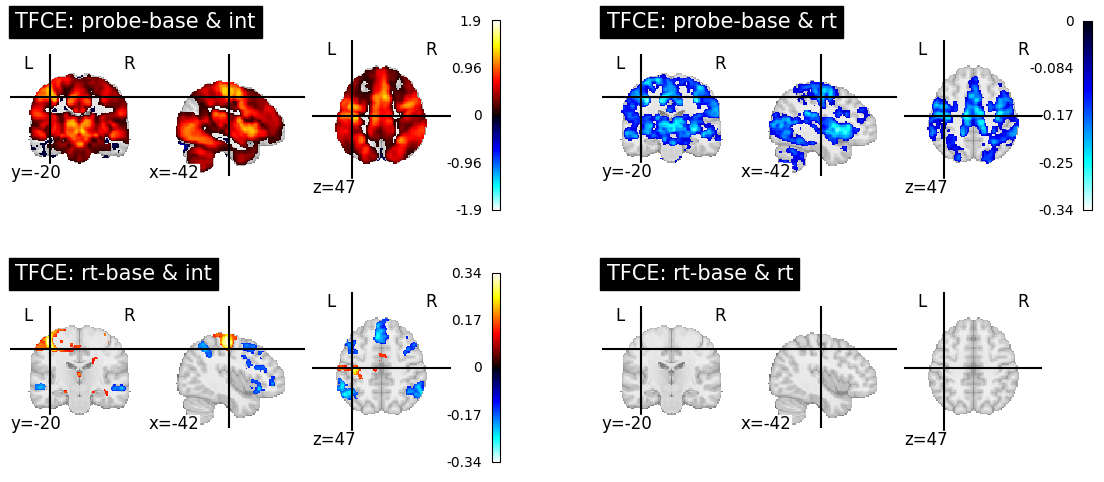

In [15]:
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6))

for i, con in enumerate(['probe-base', 'rt-base']):
    for j, val in enumerate(['int', 'rt']):
        if val == 'int':
            con_img = f'{grpmap_path}/randomise/randomise/{con}/grp/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_randomise_cohensd1.nii.gz'
            row = i  # Use i as row index
            col = j  # Use j as column index
            plotting.plot_stat_map(stat_map_img=con_img, cut_coords=lmotor_coords,
                                   display_mode="ortho",
                                   title=f"TFCE: {con} & {val}", draw_cross=True,
                                   #vmax=d_max, threshold=d_thresh
                                   colorbar=True, axes=axes[row, col])
        else:
            con_img = f'{grpmap_path}/randomise/randomise/{con}/rt/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_randomise_pearsonr1.nii.gz'
            row = i  # Use i as row index
            col = j  # Use j as column index
            plotting.plot_stat_map(stat_map_img=con_img, cut_coords=lmotor_coords,
                                   display_mode="ortho",
                                   title=f"TFCE: {con} & {val}",  draw_cross=True,
                                   #vmax=r_max, threshold=r_thresh,
                                   colorbar=True, axes=axes[row, col])
plt.show()

### 4.3.2 Average and correlation with mean RT (thresh d = .2, r = .1)

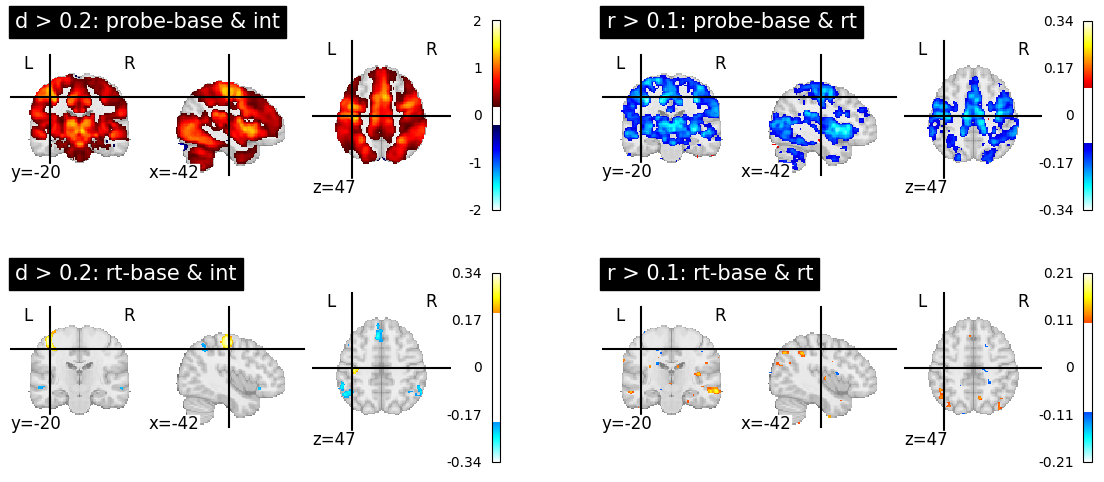

In [16]:
n_cols = 2
n_rows = 2
d_thresh=.2
d_max = 1
r_thresh=.1
r_max = .5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6))

for i, con in enumerate(['probe-base', 'rt-base']):
    for j, val in enumerate(['int', 'rt']):
        if val == 'int':
            con_img = f'{grpmap_path}/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_stat-cohensd_int.nii.gz'
            row = i  # Use i as row index
            col = j  # Use j as column index
            plotting.plot_stat_map(stat_map_img=con_img, cut_coords=lmotor_coords,
                                   display_mode="ortho",
                                   title=f"d > {d_thresh}: {con} & {val}", draw_cross=True,
                                   threshold=d_thresh,
                                   colorbar=True, axes=axes[row, col])
        else:
            con_img = f'{grpmap_path}/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_stat-pearsonr_rt.nii.gz'
            row = i  # Use i as row index
            col = j  # Use j as column index
            plotting.plot_stat_map(stat_map_img=con_img, cut_coords=lmotor_coords,
                                   display_mode="ortho",
                                   title=f"r > {r_thresh}: {con} & {val}",  draw_cross=True,
                                   threshold=r_thresh,
                                   colorbar=True, axes=axes[row, col])
plt.show()

## 4.4 Between-subject Correlation with mean RT for contrastss: `mod-Cue-None` & `mod-Cue-rt` 

### 4.4.1 Group correlation with mean RTs, TFCE p<0.05

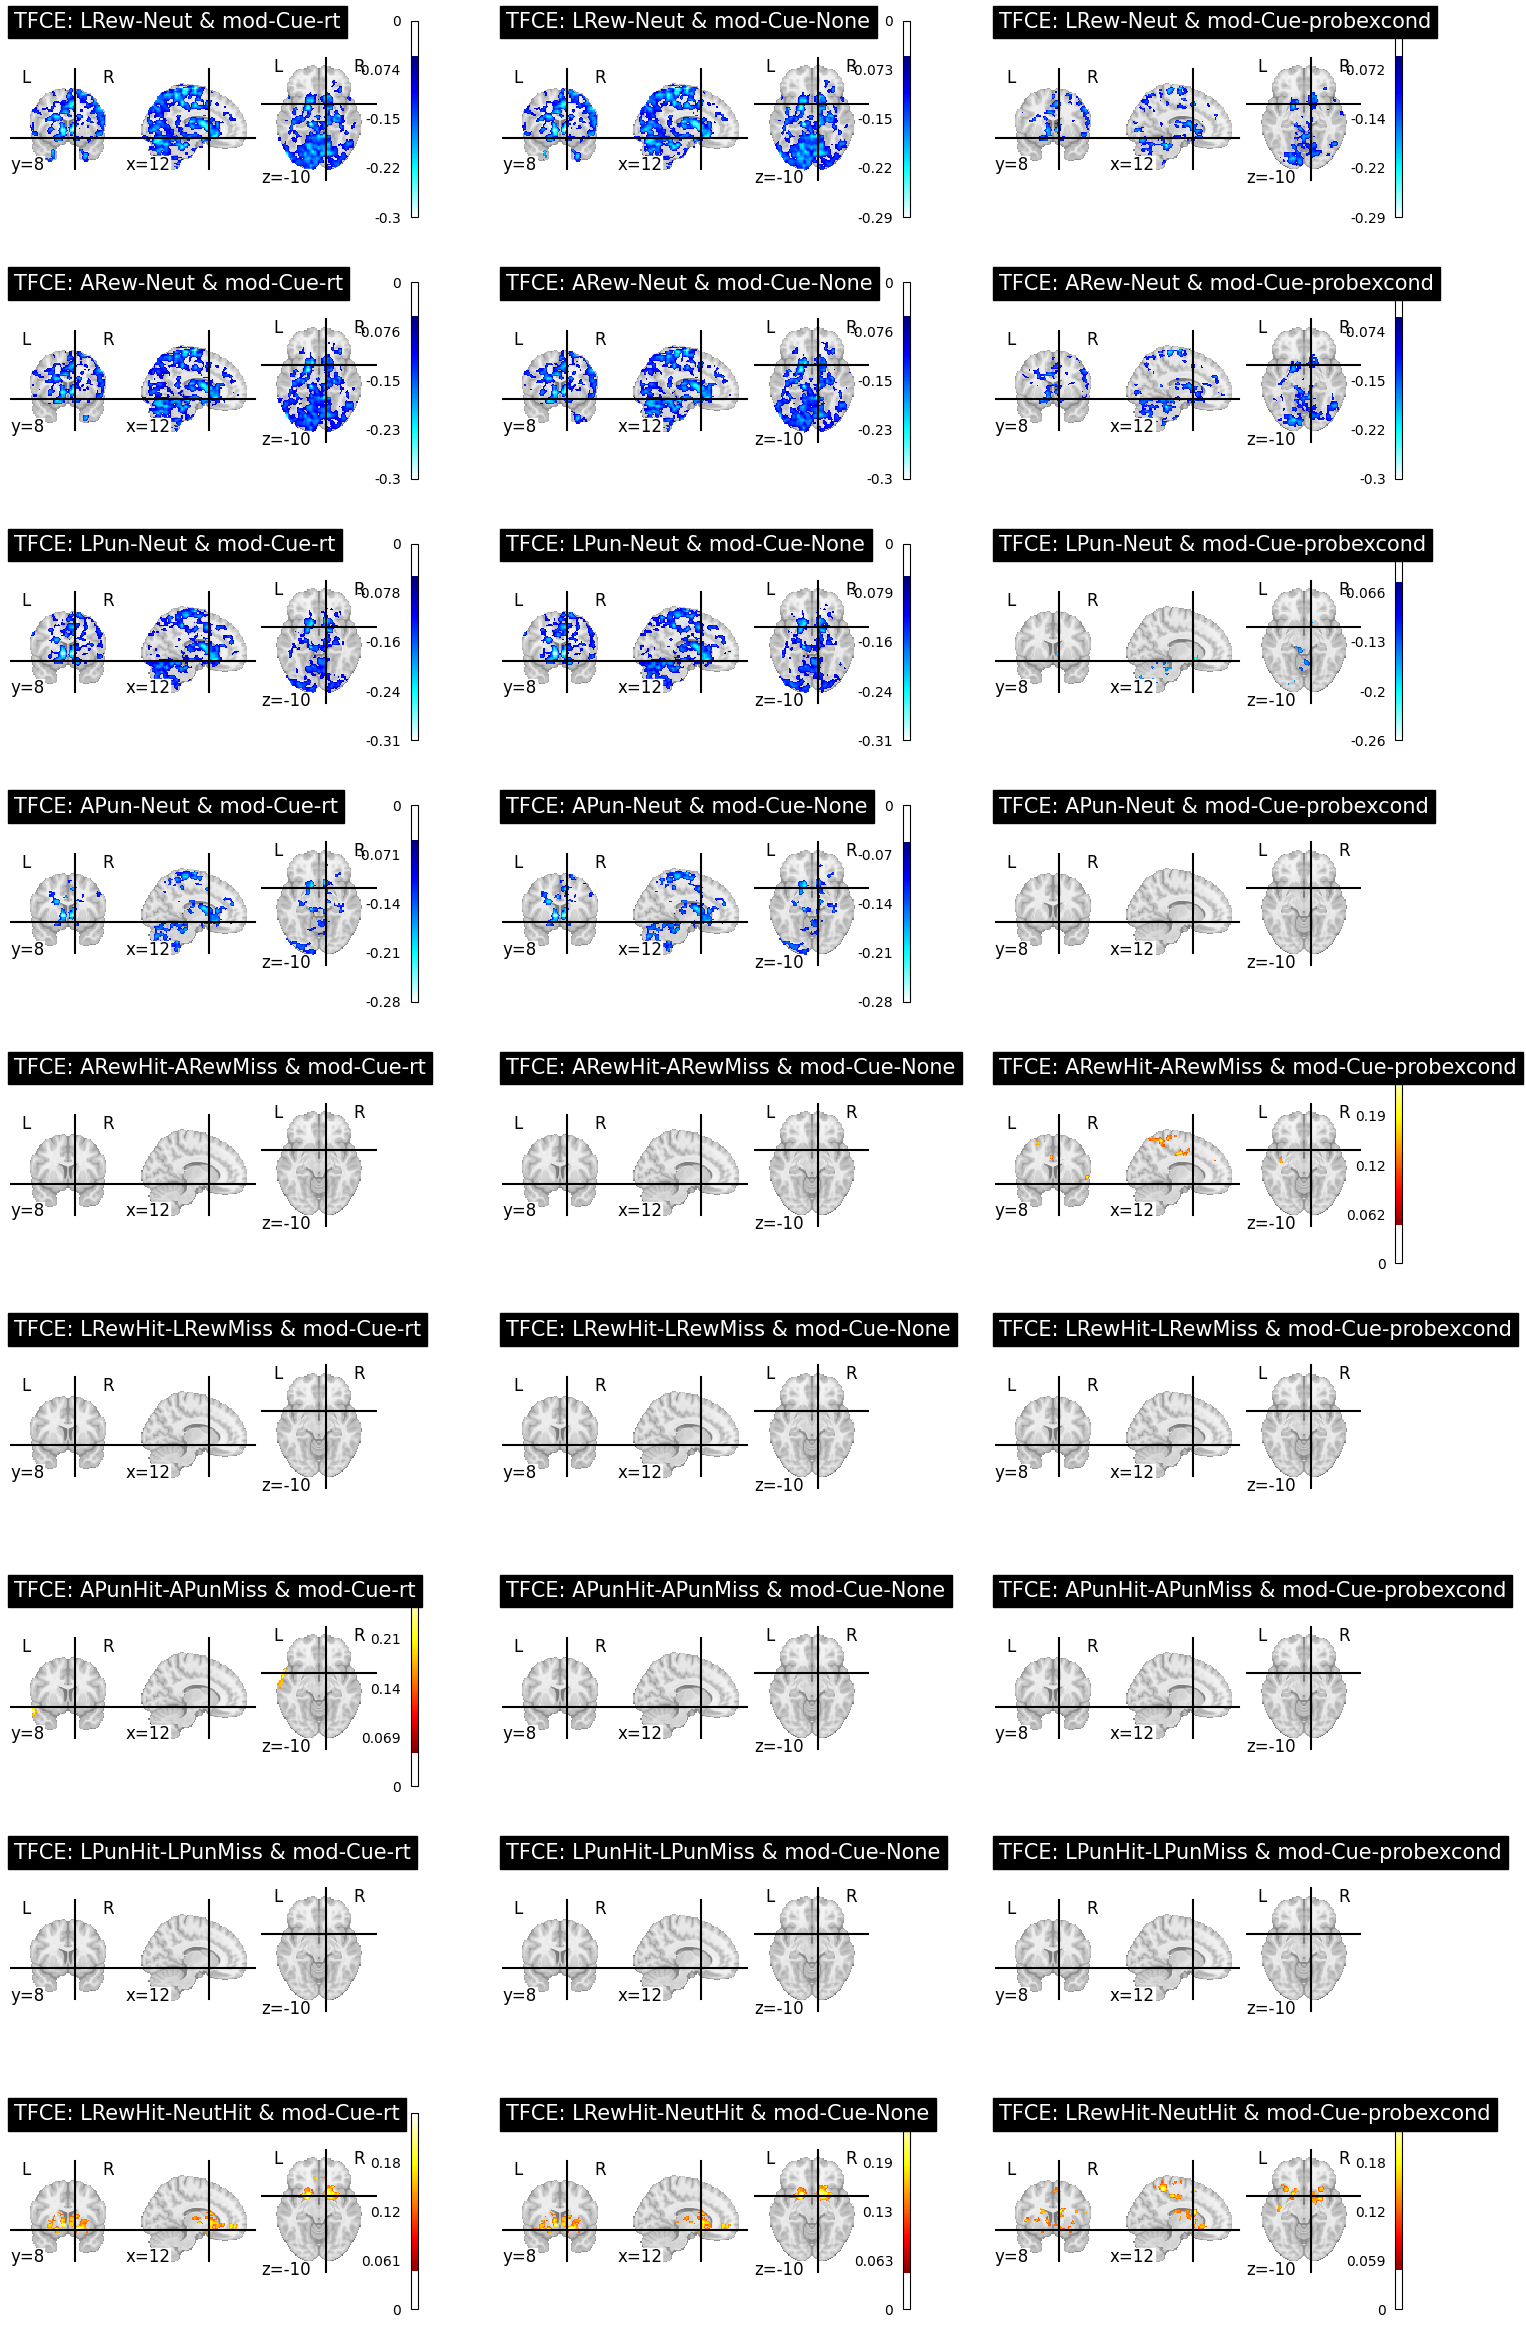

In [38]:
n_cols = 3
r_thresh = .05
r_max = .3
n_rows = len(contrasts_reg)
fig, axes = plt.subplots(len(contrasts_reg), n_cols, figsize=(18,30))

for mod in ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond']:
    for i, con in enumerate(contrasts_reg):
        con_img = f'{grpmap_path}/randomise/randomise/{con}/rt/subs-500_{session}_task-MID_contrast-{con}_{mod}_randomise_pearsonr1.nii.gz'
        col = ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond'].index(mod)
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               title=f"TFCE: {con} & {mod}", threshold=r_thresh, draw_cross=True, #vmax=r_max, 
                               colorbar=True, axes=axes[i, col])

plt.show()

### 4.4.2 Voxelwise t-stat comparisons: `mod-Cue-rt` ~ `mod-Cue-None`

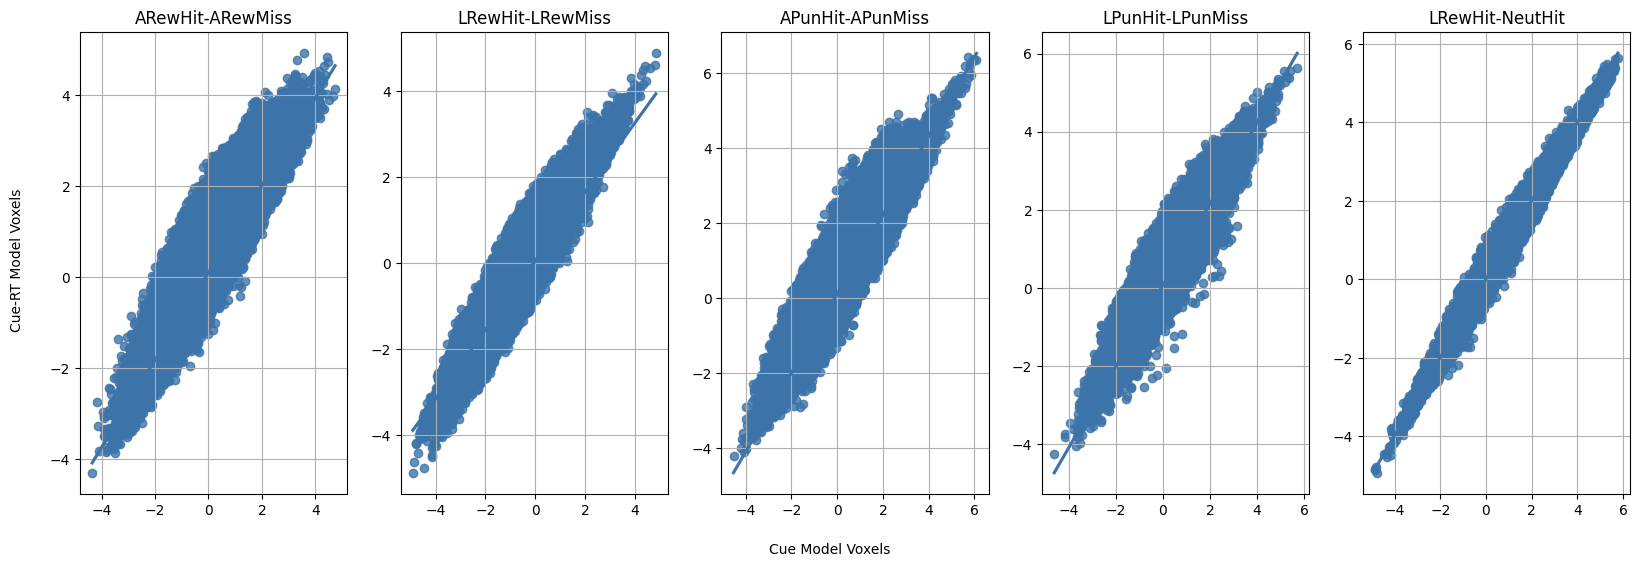

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, (label, contrast) in enumerate(fb_contrasts.items()):
    con_img_none = f'{grpmap_path}/randomise/randomise/{label}/rt/subs-500_{session}_task-MID_contrast-{label}_mod-Cue-None_randomise_tstat1.nii.gz'
    con_img_rt = f'{grpmap_path}/randomise/randomise/{label}/rt/subs-500_{session}_task-MID_contrast-{label}_mod-Cue-rt_randomise_tstat1.nii.gz'
    nonrt_tfce,rt_tfce=imgs_intersect(img1_path=con_img_none, img2_path=con_img_rt)
    nonrt_voxs = nonrt_tfce.ravel()
    rt_voxs = rt_tfce.ravel()

    # Plot in the corresponding subplot
    sns.regplot(x=nonrt_voxs, y=rt_voxs, color='#3c73a8', ax=axes[i])
    
    # Set title, labels, and add correlation coefficient to the plot
    axes[i].set_title(f'{label}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].grid(True)

fig.text(0.5, 0.01, 'Cue Model Voxels', ha='center')
fig.text(0.09, 0.5, 'Cue-RT Model Voxels', va='center', rotation='vertical')
plt.show()

### 4.4.3 Group correlation with mean RTs (thresh r = 0.05))

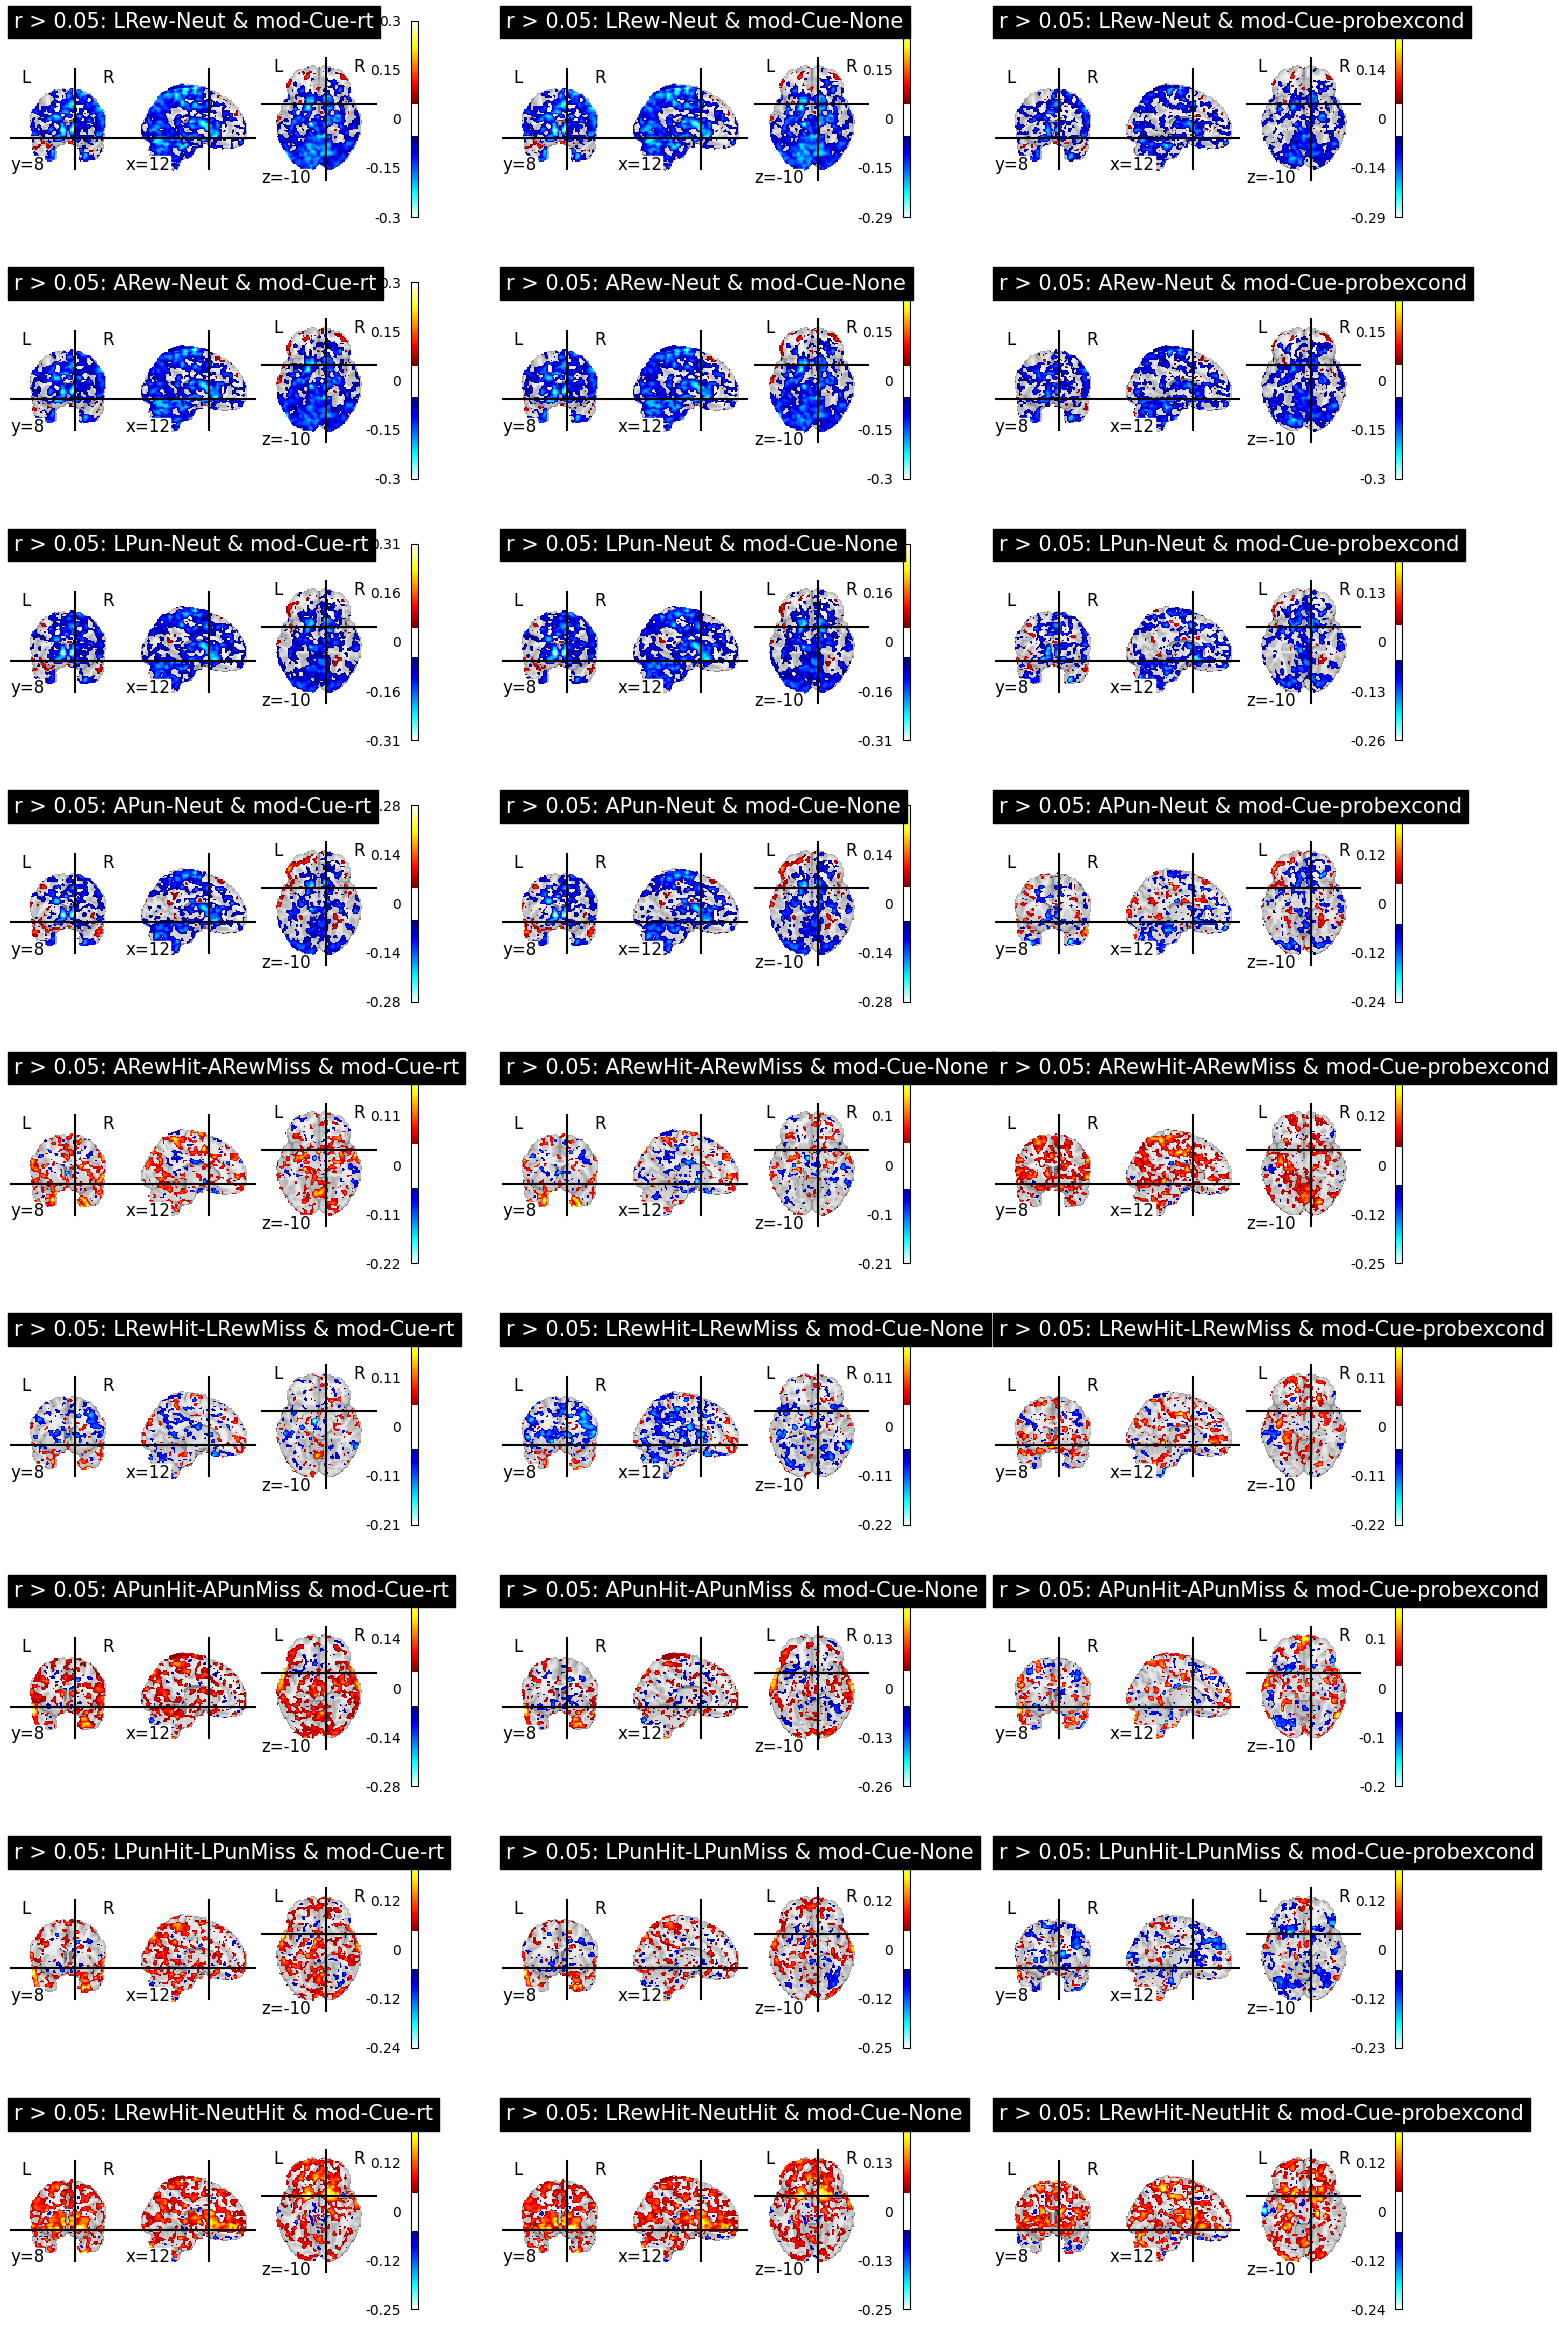

In [39]:
fig, axes = plt.subplots(len(contrasts_reg), n_cols, figsize=(18,30))

for mod in ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond']:
    for i, con in enumerate(contrasts_reg):
        con_img = f'{grpmap_path}/subs-500_{session}_task-MID_contrast-{con}_{mod}_stat-pearsonr_rt.nii.gz'
        col = ['mod-Cue-rt', 'mod-Cue-None', 'mod-Cue-probexcond'].index(mod)
        plotting.plot_stat_map(stat_map_img=con_img, cut_coords=spec_coords,  # Right NAcc
                               display_mode="ortho",
                               title=f"r > {r_thresh}: {con} & {mod}", threshold=r_thresh, draw_cross=True, #vmax=r_max, 
                               colorbar=True, axes=axes[i, col])

plt.show()

## 4.5 Correlation differences (group correlation w/ mean RT): `mod-Cue-None` - `mod-Cue-rt`

### 4.5.1 RT Corr Diff: `mod-Cue-None` – `mod-Cue-rt` (thresholded conjunction TFCE p < .05)

/home/faird/mdemiden/.conda/envs/fmri_env/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


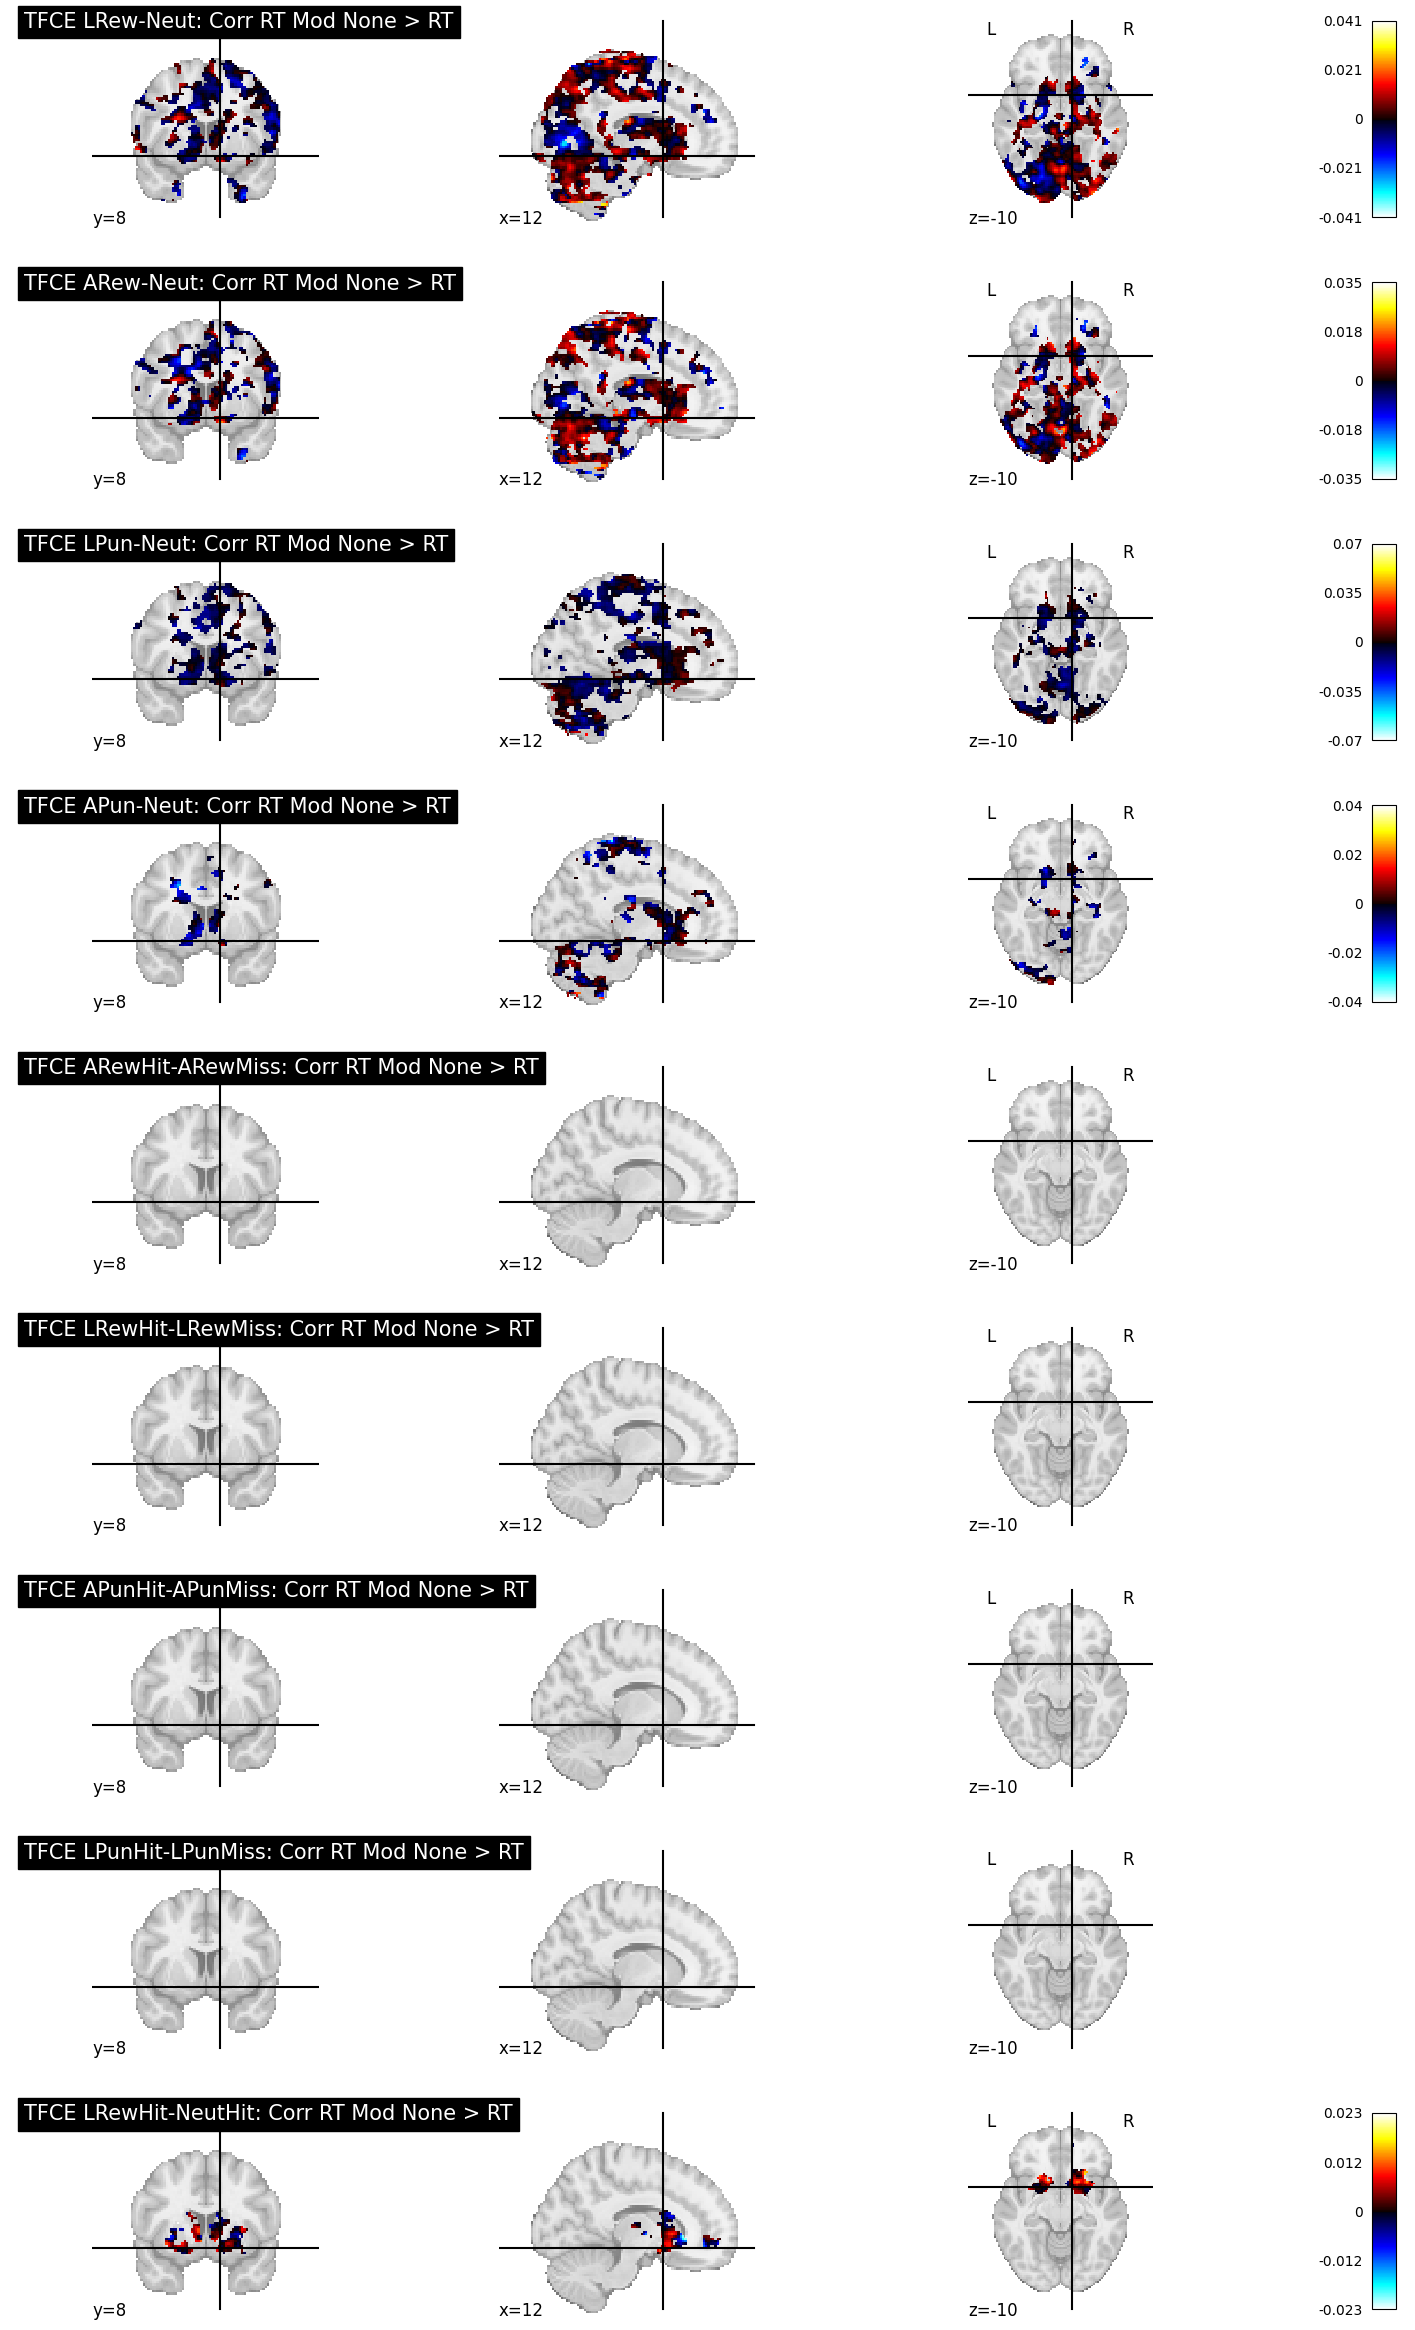

In [21]:
rt_minus_none = []
r_thresh = .05
r_max = .15
for con in contrasts_reg:
    con_img_none = f'{grpmap_path}/randomise/randomise/{con}/rt/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-None_randomise_pearsonr1.nii.gz'
    con_img_rt = f'{grpmap_path}/randomise/randomise/{con}/rt/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_randomise_pearsonr1.nii.gz'
    difference = diff_intersect_imgs(non_mod_img=con_img_none, rt_mod_img=con_img_rt)
    rt_minus_none.append((difference, con))  # Store the difference image along with the contrast label

fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, (img, con) in enumerate(rt_minus_none):
    plotting.plot_stat_map(stat_map_img=img, cut_coords=spec_coords,
                           display_mode="ortho",
                           title=f"TFCE {con}: Corr RT Mod None > RT", draw_cross=True,
                           #vmax=r_max, threshold=r_thresh,
                           colorbar=True,axes=axes[i])

plt.show()

### 5.2.2 RT correlation difference: `mod-Cue-None` - `mod-Cue-rt` (threshold r diff = .05)

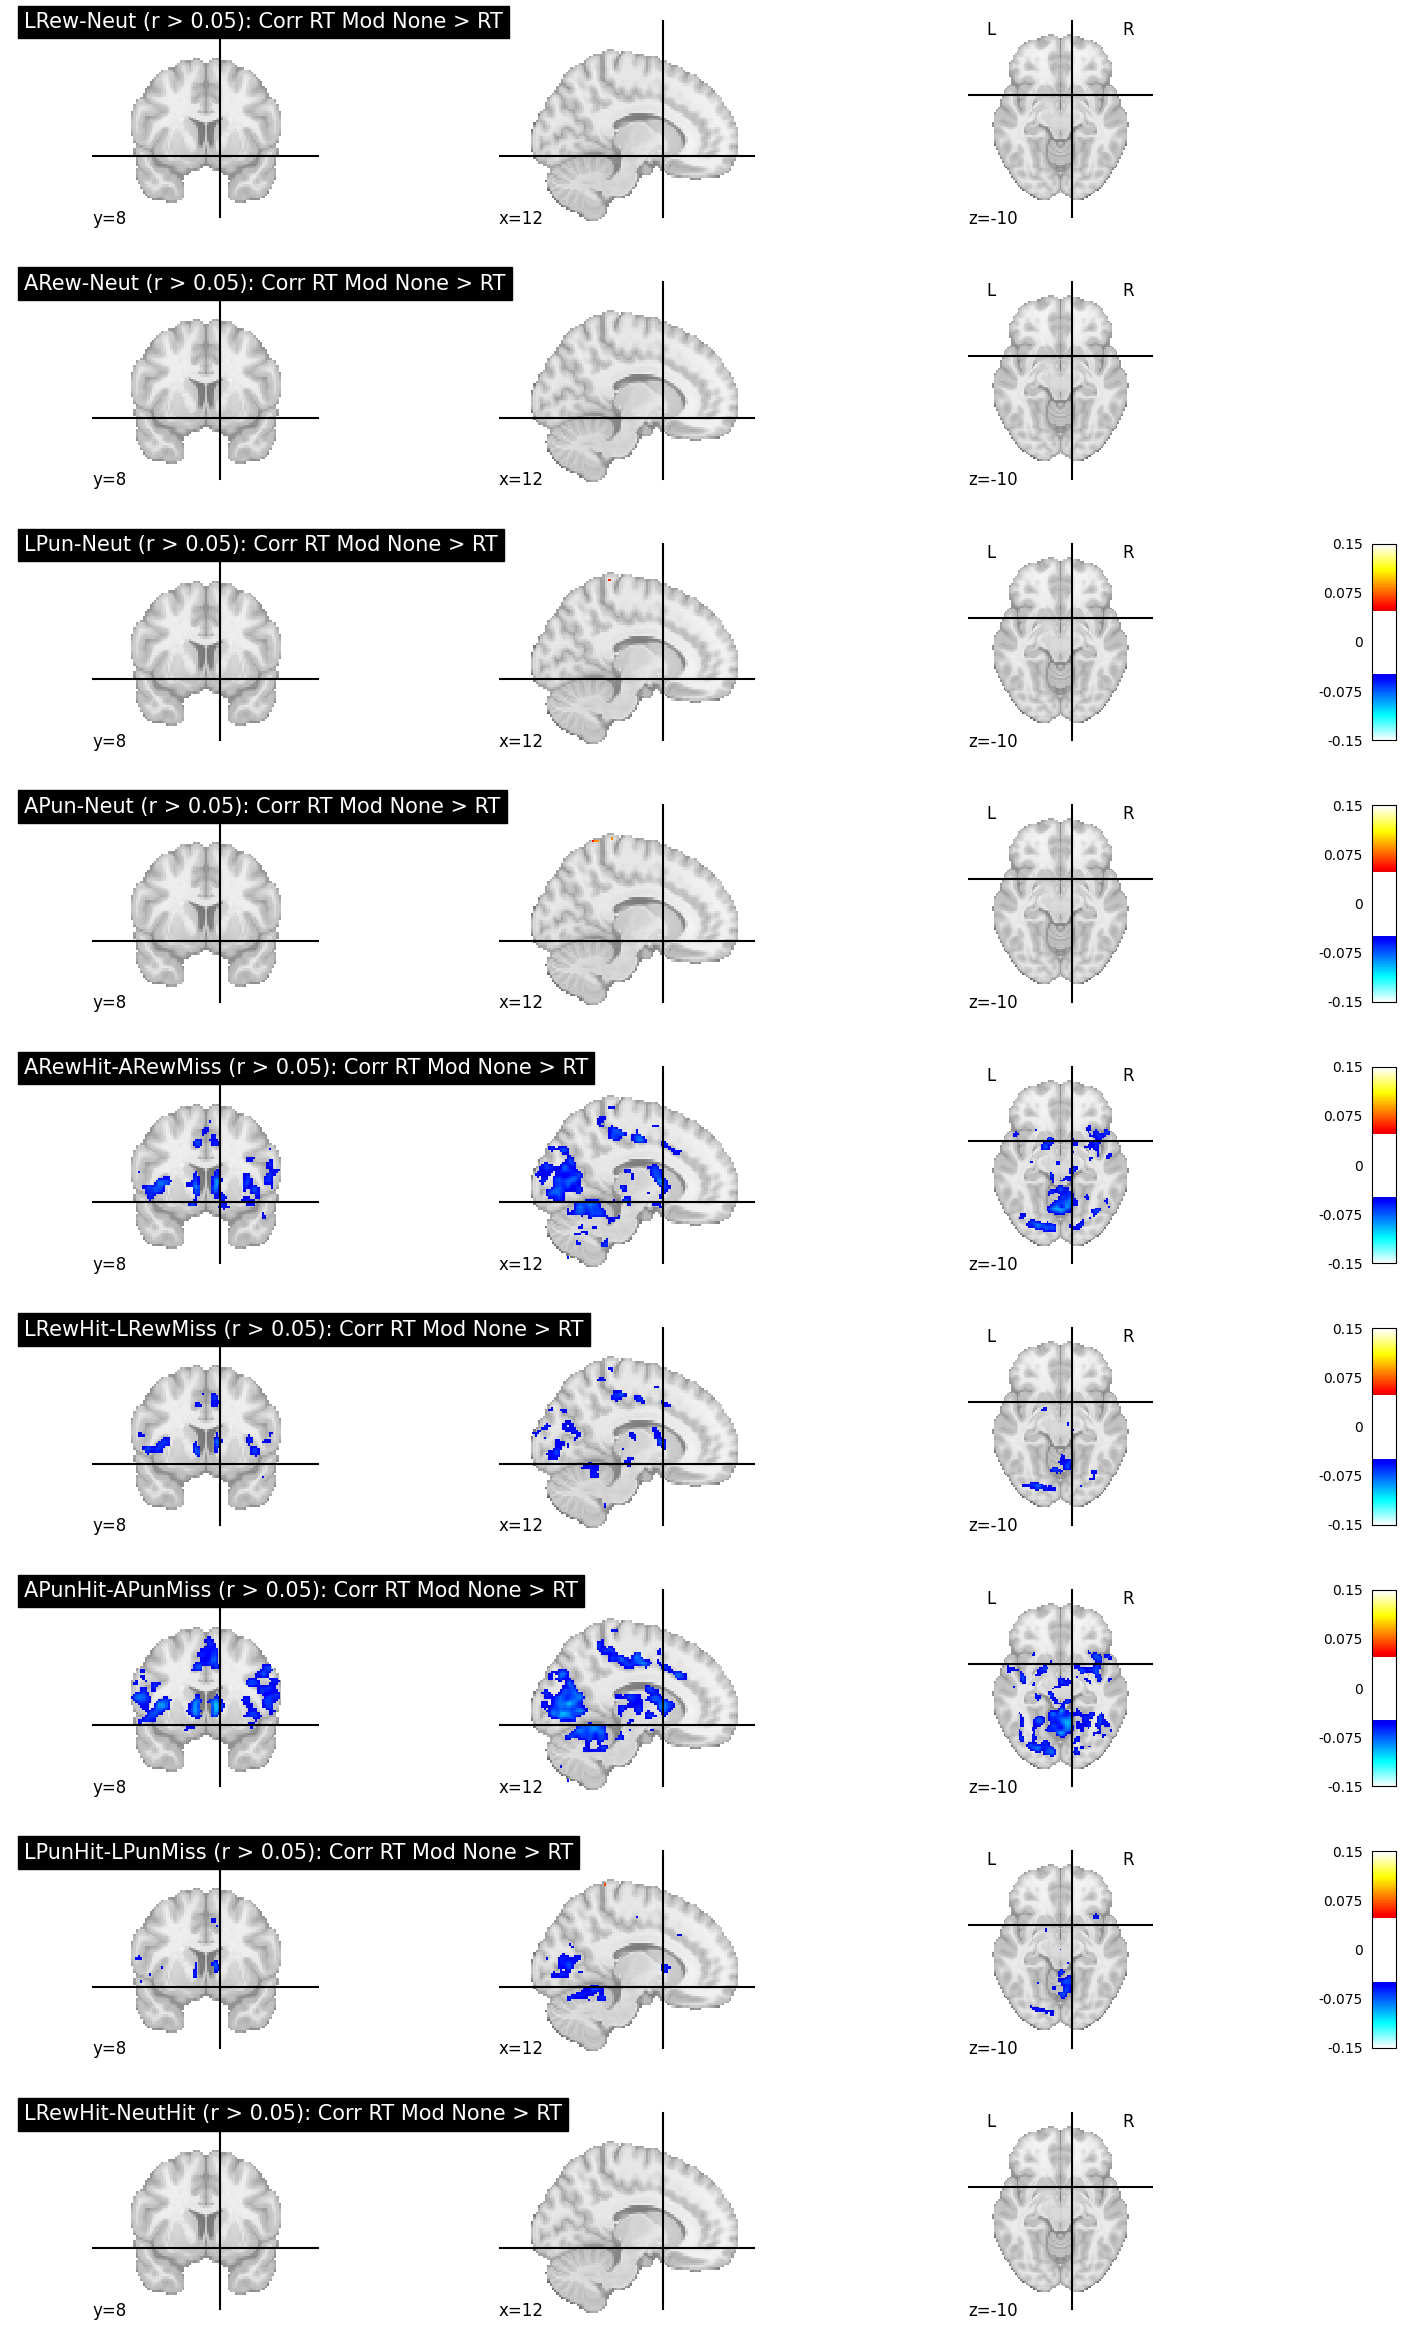

In [22]:
rt_minus_none = []
r_thresh = .05
r_max = .15
for con in contrasts_reg:
    con_img_none = f'{grpmap_path}/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-None_stat-pearsonr_rt.nii.gz'
    con_img_rt = f'{grpmap_path}/subs-500_{session}_task-MID_contrast-{con}_mod-Cue-rt_stat-pearsonr_rt.nii.gz'
    difference = diff_intersect_imgs(non_mod_img=con_img_none, rt_mod_img=con_img_rt)
    rt_minus_none.append((difference, con))  # Store the difference image along with the contrast label

fig, axes = plt.subplots(len(contrasts_reg), 1, figsize=(18, 30))
for i, (img, con) in enumerate(rt_minus_none):
    plotting.plot_stat_map(stat_map_img=img, cut_coords=spec_coords,
                           display_mode="ortho",
                           title=f"{con} (r > {r_thresh}): Corr RT Mod None > RT", threshold=r_thresh, draw_cross=True,
                           vmax=r_max, colorbar=True,
                           axes=axes[i])

plt.show()

# 5. Example RT Design Matrix (w/o cosine+mot)

Set paths and load the behavioral data for n = 1

In [150]:
beh_n1 = glob(f'{beh_path}/*_task-MID_run-01_events.tsv')[3]

In [151]:
events_df = pd.read_csv(beh_n1,sep='\t')
events_df.columns

Index(['Subject', 'Handedness', 'Run', 'SubTrial', 'Condition',
       'Cue.OnsetTime', 'Cue.Duration', 'Anticipation.Duration',
       'Anticipation.OnsetTime', 'Probe.Duration', 'Probe.OnsetTime',
       'Probe.RESP', 'Result', 'prbacc', 'prbrt', 'OverallRT', 'meanrt',
       'moneyamt', 'ResponseCheck', 'Feedback.OnsetTime', 'FeedbackDuration',
       'SessionDate', 'TriggerTime', 'TriggerTimeAlt', 'DiffTriggerTimes',
       'scantrig_col', 'calibrend_col', 'eprime_readtype'],
      dtype='object')

In [152]:
events_df[['Probe.Duration', 'Probe.OnsetTime','OverallRT']]

Probe.Duration  Probe.OnsetTime  OverallRT
0            0.276            5.465      290.0
1            0.276           10.979      263.0
2            0.276           18.475      272.0
3            0.276           23.990        NaN
4            0.276           31.520      282.0
5            0.316           38.533      240.0
6            0.316           44.030      287.0
7            0.316           49.528       93.0
8            0.336           56.525      300.0
9            0.336           62.023      273.0
10           0.336           68.036      239.0
11           0.306           74.033      401.0
12           0.306           80.530      324.0
13           0.306           86.045      188.0
14           0.306           92.542      350.0
15           0.286           98.056      324.0
16           0.286          103.553      346.0
17           0.286          111.050      280.0
18           0.326          116.547      346.0
19           0.326          124.044      311.0
20           0.326          130.541      242.0
21           0.366          136.538      287.0
22           0.366          142.536      420.0
23           0.366          150.565      252.0
24           0.366          156.563      373.0
25           0.416          162.077      269.0
26           0.416          169.073      250.0
27           0.416          175.071      349.0
28           0.436          180.568        NaN
29           0.436          186.565      456.0
30           0.436          194.579      797.0
31           0.436          202.592      363.0
32           0.436          210.105      222.0
33           0.436          215.602      397.0
34           0.436          221.100      621.0
35           0.416          229.113      246.0
36           0.416          234.610      661.0
37           0.416          240.608      292.0
38           0.416          247.105      452.0
39           0.466          252.602      319.0
40           0.466          258.100      455.0
41           0.466          264.097      265.0
42           0.486          269.611      269.0
43           0.486          275.109      270.0
44           0.486          280.623      322.0
45           0.456          288.636      345.0
46           0.456          295.633      519.0
47           0.456          302.646      292.0
48           0.456          309.143      289.0
49           0.426          315.158        NaN

## 5.1 Set up condition and conditional RT examples. 

Question...

ABCD - 
Reward Hit - Reward Miss ($5/0.20)
Reward Hit - Neutral hit 

If RT effect - adjust If contrast for feedback --> decreases effect = okay?

First: Create a more consistent hit/miss Feedback column based on probe accuracy

In [197]:
events_df['Feedback.Response'] = np.where(events_df['prbacc'] == 1.0,
                                          events_df['Condition'] + '_hit',
                                          events_df['Condition'] + '_miss')
events_df['Probe.Type'] = np.where(events_df['prbacc'] == 1.0,
                                   'prbhit_' + events_df['Condition'],
                                   'prbmiss_' + events_df['Condition'])
events_df['probe_hit_onset'] = np.where(events_df['prbacc'] == 1.0,events_df['Probe.OnsetTime'], np.nan)
events_df['probe_hit_dur'] = np.where(events_df['prbacc'] == 1.0,events_df['Probe.Duration'], np.nan)

events_df['probe_miss_onset'] = np.where(events_df['prbacc'] == 0.0,events_df['Probe.OnsetTime'], np.nan)
events_df['probe_miss_dur'] = np.where(events_df['prbacc'] == 0.0,events_df['Probe.Duration'], np.nan)

In [154]:
events_df[['Feedback.Response','OverallRT']].groupby('Feedback.Response').mean('OverallRT')

OverallRT
Feedback.Response            
LgPun_hit          310.250000
LgPun_miss         319.833333
LgReward_hit       300.200000
LgReward_miss      350.000000
SmallPun_hit       278.857143
SmallPun_miss      276.000000
SmallReward_hit    253.000000
SmallReward_miss   458.750000
Triangle_hit       344.000000
Triangle_miss      476.000000

## 5.2 Set up design matrix

Create stacked conditions, onsets and durations to be used in first level. 

In order of phases modeled:

Anticipation:
1. Condition
2. Cue.OnsetTime
3. Cue.Duration

Feedback:
1. Feedback.Response
2. Feedback.OnsetTime
3. Feedback.Duration

Two probe regressor:

Probe - Regressor 1: Probe.OnsetTime + Probe.duration

Prone_rt - Regressor 2: Probe.OnsetTime + OverallRT / 1000

Probe:
1. Constant probe cue
2. Probe.OnsetTime
3. Probe.Duration

Probe_rt:
1. Constant probe_rt label -- omit rows w/o response
2. Probe.OnsetTime -- omit rows w/o response
3. OverallRT -- duration is the RT time, omit rows w/o response (ms --> sec)



In [198]:
# vols / tr
num_volumes = 403
bold_tr = .800

# Using the BOLD tr and volumes to generate the frame_times: acquisition time in seconds
frame_times = np.arange(num_volumes) * bold_tr

### 5.2.1 No RT Model Design Matrix

In [199]:
conditions = pd.concat([events_df.loc[:, 'Condition'], 
                        events_df.loc[:, 'Feedback.Response']
                       ], ignore_index=True)
onsets = pd.concat([events_df.loc[:, 'Cue.OnsetTime'], 
                    events_df.loc[:, 'Feedback.OnsetTime']
                   ], ignore_index=True)
duration = pd.concat([events_df.loc[:, 'Cue.Duration'], 
                      events_df.loc[:, 'FeedbackDuration']
                     ], ignore_index=True)

# create pandas df with events
design_cue = pd.DataFrame({
    'trial_type': conditions,
    'onset': onsets,
    'duration': duration
})

In [200]:
design_matrix_cue = make_first_level_design_matrix(
    frame_times=frame_times,
    events=design_cue,
    hrf_model='spm', drift_model=None, add_regs=None
    )

In [201]:
vif_cue = pd.DataFrame()
vif_cue["Var"] = design_matrix_cue.columns
vif_cue["VIF"] = [round(variance_inflation_factor(design_matrix_cue.values, i),1) for i in range(design_matrix_cue.shape[1])]

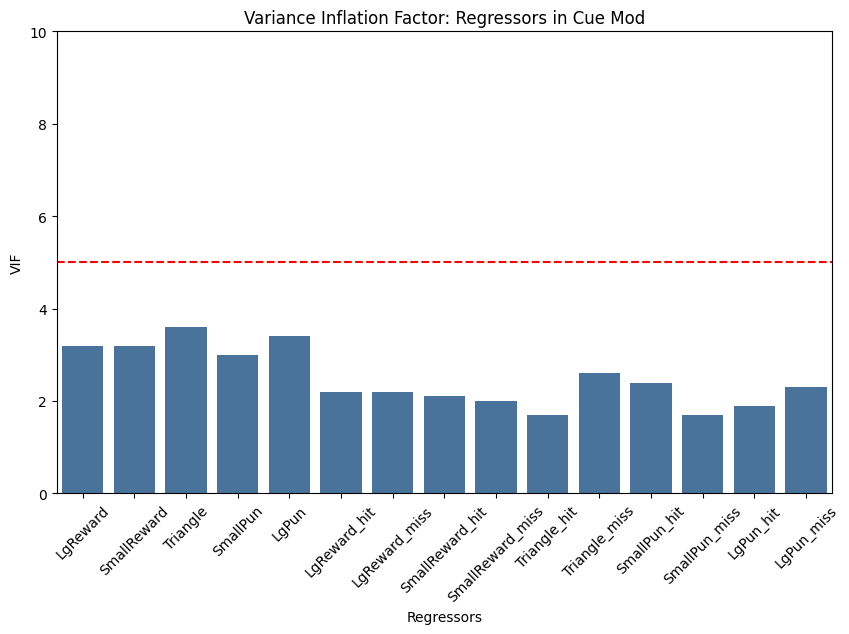

In [202]:
model = 'Cue Mod'
reorder_cols = ['LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
                'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
                'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
                'LgPun_hit', 'LgPun_miss']

plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', data=vif_cue, order = reorder_cols, color='#3c73a8')
plt.ylim(0,10)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {model}')
plt.xticks(rotation=45, fontsize=10)  
plt.show()

### 5.2.2 RT Model Design Matrix

In [203]:
conditions = pd.concat([events_df.loc[:, 'Condition'], 
                        events_df.loc[:, 'Feedback.Response'],
                        pd.Series(['probe'] * len(events_df[['OverallRT','Probe.OnsetTime']])),
                        pd.Series(['probe_rt'] * len(events_df[['OverallRT','Probe.OnsetTime']].dropna()))
                       ], ignore_index=True)
onsets = pd.concat([events_df.loc[:, 'Cue.OnsetTime'], 
                    events_df.loc[:, 'Feedback.OnsetTime'],
                    events_df.loc[:, 'Probe.OnsetTime'],
                    events_df[['OverallRT','Probe.OnsetTime']].dropna()['Probe.OnsetTime']
                   ], ignore_index=True)
duration = pd.concat([events_df.loc[:, 'Cue.Duration'], 
                      events_df.loc[:, 'FeedbackDuration'],
                      events_df.loc[:, 'Probe.Duration'],
                      (events_df[['OverallRT','Probe.OnsetTime']].dropna()['OverallRT'])/1000
                     ], ignore_index=True)

# create pandas df with events
design_rt = pd.DataFrame({
    'trial_type': conditions,
    'onset': onsets,
    'duration': duration
})

In [38]:
design_rt

trial_type    onset  duration
0     SmallPun    2.033     2.000
1        LgPun    7.530     2.000
2     Triangle   13.028     2.000
3     Triangle   20.508     2.000
4     LgReward   26.055     2.000
..         ...      ...       ...
192   probe_rt  280.623     0.322
193   probe_rt  288.636     0.345
194   probe_rt  295.633     0.519
195   probe_rt  302.646     0.292
196   probe_rt  309.143     0.289

[197 rows x 3 columns]

In [204]:
design_matrix_rt = make_first_level_design_matrix(
    frame_times=frame_times,
    events=design_rt,
    hrf_model='spm', drift_model=None, add_regs=None
    )

In [205]:
vif_rt = pd.DataFrame()
vif_rt["Var"] = design_matrix_rt.columns
vif_rt["VIF"] = [round(variance_inflation_factor(design_matrix_rt.values, i),1) for i in range(design_matrix_rt.shape[1])]

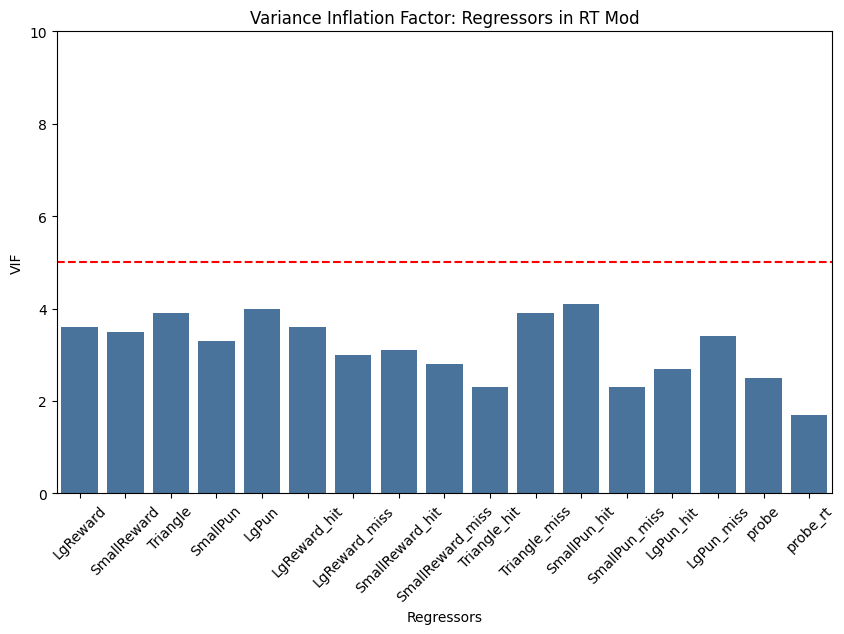

In [206]:
model = 'RT Mod'
rt_order = ['LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
            'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
            'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
            'LgPun_hit', 'LgPun_miss', 'probe','probe_rt']

plt.figure(figsize=(10, 6))
sns.barplot(x='Var', y='VIF', data=vif_rt, order = rt_order, color='#3c73a8')
plt.ylim(0,10)
plt.xlabel('Regressors')
plt.ylabel('VIF')
plt.axhline(y=5, color='r', linestyle='--')
plt.title(f'Variance Inflation Factor: Regressors in {model}')
plt.xticks(rotation=45, fontsize=10)  
plt.show()

### 5.2.3 RT model NA miss trials Design Matrix

In [207]:
conditions = pd.concat([events_df.loc[:, 'Condition'], 
                        events_df.loc[:, 'Feedback.Response'],
                        events_df.loc[:, 'Probe.Type']
                       ], ignore_index=True)
onsets = pd.concat([events_df.loc[:, 'Cue.OnsetTime'], 
                    events_df.loc[:, 'Feedback.OnsetTime'],
                    events_df.loc[:, 'Probe.OnsetTime']
                   ], ignore_index=True)

duration = pd.concat([events_df.loc[:, 'Cue.Duration'], 
                      events_df.loc[:, 'FeedbackDuration'],
                      events_df.loc[:, 'Probe.Duration']
                     ], ignore_index=True)

# create pandas df with events
design_nart = pd.DataFrame({
    'trial_type': conditions,
    'onset': onsets,
    'duration': duration
})

In [208]:
design_matrix_nart = make_first_level_design_matrix(
    frame_times=frame_times,
    events=design_nart,
    hrf_model='spm', drift_model=None, add_regs=None
    )

In [209]:
vif_nart = pd.DataFrame()
vif_nart["Var"] = design_matrix_nart.columns
vif_nart["VIF"] = [round(variance_inflation_factor(design_matrix_nart.values, i),1) for i in range(design_matrix_nart.shape[1])]

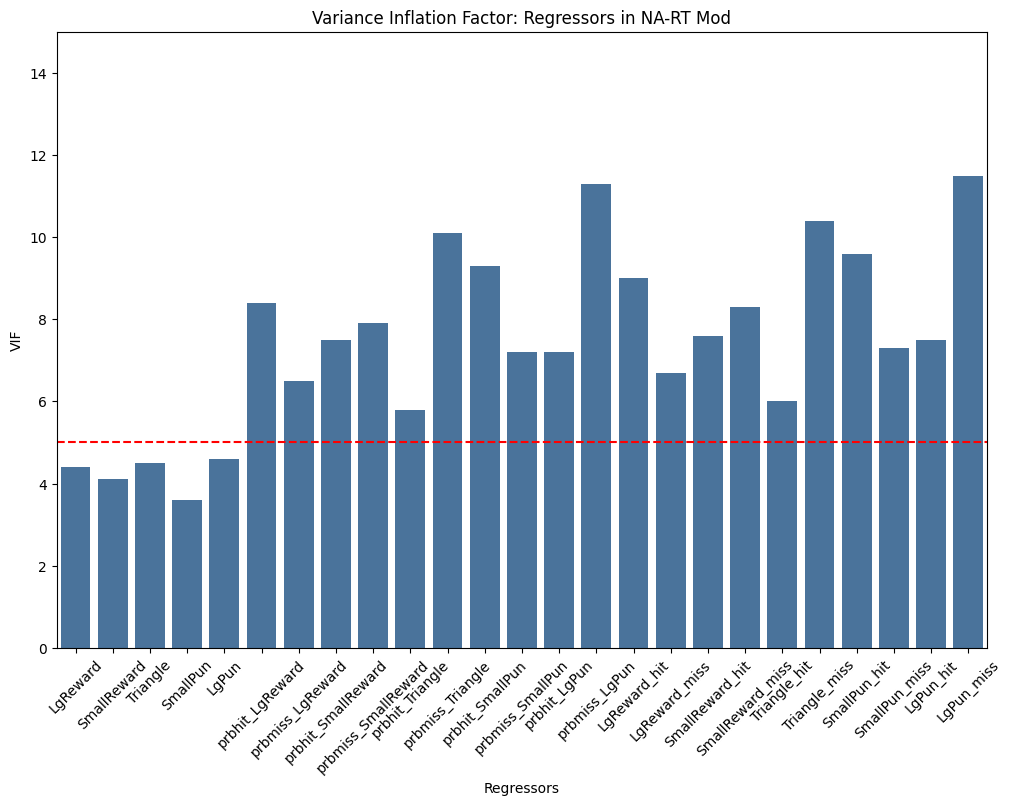

In [211]:
model = 'NA-RT Mod'
nart_order = [# anticipation (5)
            'LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
            # probe (10)
            'prbhit_LgReward', 'prbmiss_LgReward', 'prbhit_SmallReward', 'prbmiss_SmallReward',
            'prbhit_Triangle', 'prbmiss_Triangle', 'prbhit_SmallPun', 'prbmiss_SmallPun',
            'prbhit_LgPun', 'prbmiss_LgPun',
            # Feedback (10)
            'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
            'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
            'LgPun_hit', 'LgPun_miss']

plt.figure(figsize=(12, 8))
sns.barplot(x='Var', y='VIF', data=vif_nart, order = nart_order, color='#3c73a8')
plt.ylim(0,15)
plt.xlabel('Regressors')
plt.axhline(y=5, color='r', linestyle='--')
plt.ylabel('VIF')
plt.title(f'Variance Inflation Factor: Regressors in {model}')
plt.xticks(rotation=45, fontsize=10)  
plt.show()

# 5.3 Plot design matrices for models

Create nilean design matrix for n volumes + bold TR in MID ABCD w/o stc and spm model.
Subsequent versions will include dift models calculated by fmriprep + x,y,z + derivatives motion regressors

## 5.3.1 `Cue Model Design matrix`

In [212]:
reorder_cols = ['constant',
                'LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
                'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
                'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
                'LgPun_hit', 'LgPun_miss']
design_matrix_cue = design_matrix_cue.reindex(columns=reorder_cols)
print("Size of design matrix minus intercept:", design_matrix_cue.shape[-1]-1)

Size of design matrix minus intercept: 15


<AxesSubplot:label='conditions', ylabel='scan number'>

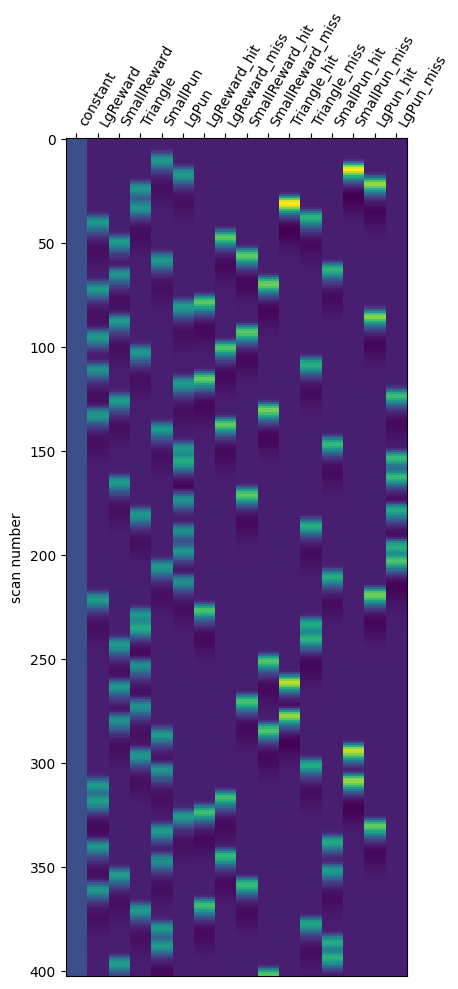

In [213]:
plotting.plot_design_matrix(design_matrix_cue)

## 5.3.2 `Cue-RT Model Design matrix`

In [214]:
reorder_cols = ['constant',
                'LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
                'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
                'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
                'LgPun_hit', 'LgPun_miss', 'probe','probe_rt']
design_matrix_rt = design_matrix_rt.reindex(columns=reorder_cols)
print("Size of design matrix minus intercept:", design_matrix_rt.shape[-1]-1)

Size of design matrix minus intercept: 17


<AxesSubplot:label='conditions', ylabel='scan number'>

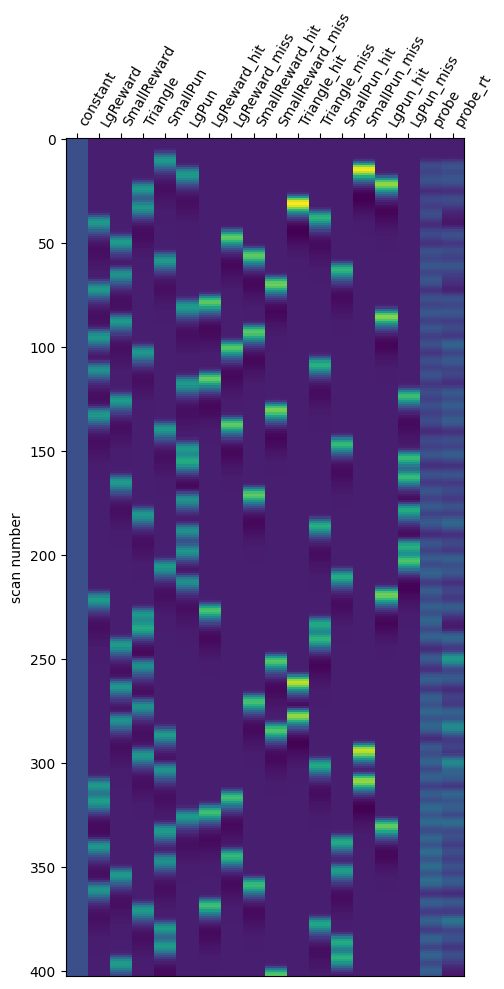

In [215]:
plotting.plot_design_matrix(design_matrix_rt)

## 5.3.3 `Cue-NART  Model Design matrix`

In [216]:
reorder_cols = ['constant',
                # anticipation (5)
                'LgReward', 'SmallReward', 'Triangle', 'SmallPun', 'LgPun',
                # probe (10)
                'prbhit_LgReward', 'prbmiss_LgReward', 'prbhit_SmallReward', 'prbmiss_SmallReward',
                'prbhit_Triangle', 'prbmiss_Triangle', 'prbhit_SmallPun', 'prbmiss_SmallPun',
                'prbhit_LgPun', 'prbmiss_LgPun',
                # Feedback (10)
                'LgReward_hit', 'LgReward_miss', 'SmallReward_hit', 'SmallReward_miss',
                'Triangle_hit', 'Triangle_miss', 'SmallPun_hit', 'SmallPun_miss',
                'LgPun_hit', 'LgPun_miss']

design_matrix_nart = design_matrix_nart.reindex(columns=reorder_cols)
print("Size of design matrix minus intercept:", design_matrix_nart.shape[-1]-1)

Size of design matrix minus intercept: 25


<AxesSubplot:label='conditions', ylabel='scan number'>

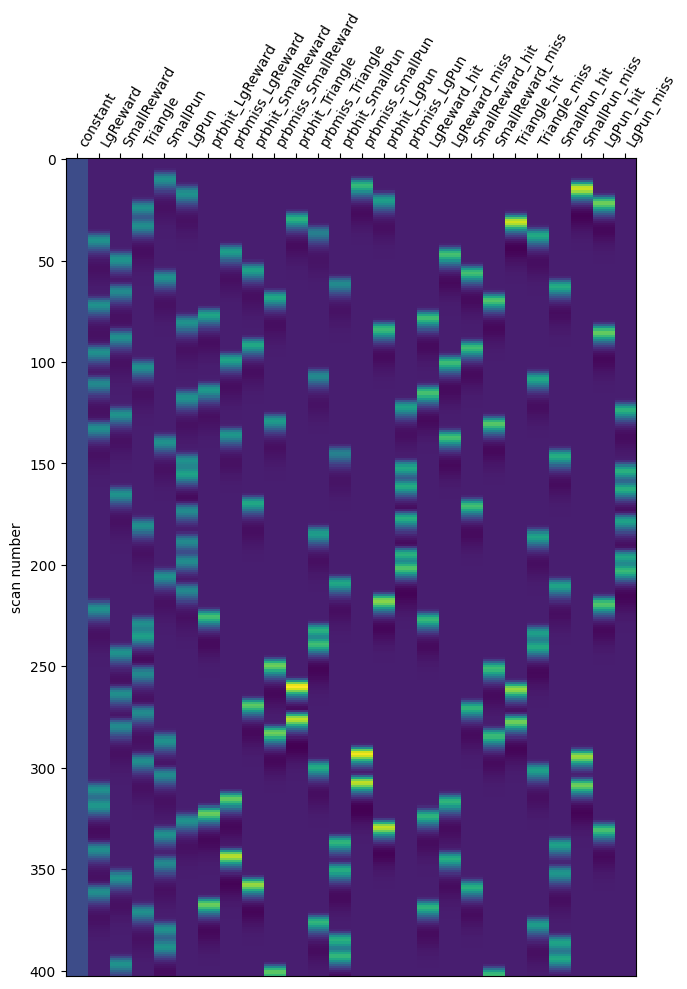

In [217]:
plotting.plot_design_matrix(design_matrix_nart)

## 5.4 Example of contrasts and contrast matrix

In [229]:
contrast_labs = {
    # Anticipation
    'LRew-Neut': 'LgReward - Triangle',
    'ARew-Neut': 'LgReward + SmallReward - 2*Triangle',
    'LPun-Neut': 'LgPun - Triangle',
    'APun-Neut': 'LgPun + SmallPun - 2*Triangle',

    # Feedback
    'ARewHit-ARewMiss': 'LgReward_hit + SmallReward_hit - LgReward_miss - SmallReward_miss',
    'LRewHit-LRewMiss': 'LgReward_hit - LgReward_miss',
    'APunHit-APunMiss': 'LgPun_hit + SmallPun_hit - LgPun_miss - SmallPun_miss',
    'LPunHit-LPunMiss': 'LgPun_hit - LgPun_miss',
    'LRewHit-NeutHit': 'LgReward_hit - Triangle_hit',

    #probe
    'probe-base': 'probe',
    'rt-base': 'probe_rt'

}

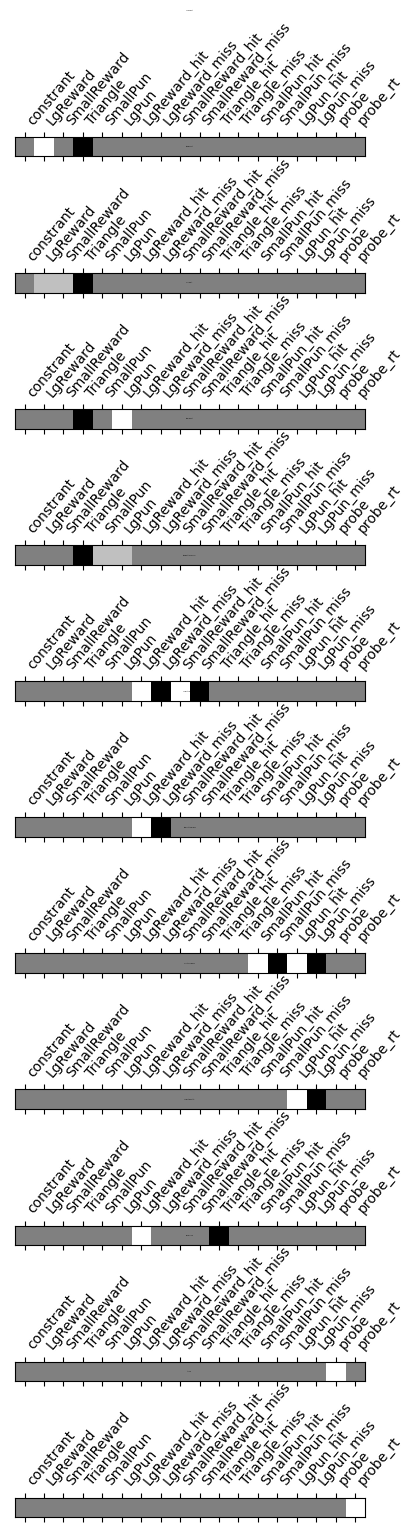

In [230]:
fig, axes = plt.subplots(nrows=len(contrast_labs), ncols=1, figsize=(400, 40))

# Plot each contrast matrix on a separate subplot
for i, (key, values) in enumerate(contrast_labs.items()):
    ax = axes[i]  # Select the appropriate subplot
    plotting.plot_contrast_matrix(values, design_matrix=design_matrix_mid, ax=ax)
    ax.set_title(key, fontsize=.0005)  # Set title for each subplot with smaller font size
plt.subplots_adjust(hspace=6)  # Add space between subplots
plt.show()

In [231]:
vals = design_matrix_mid.columns.values
print(' '.join(vals))

constrant LgReward SmallReward Triangle SmallPun LgPun LgReward_hit LgReward_miss SmallReward_hit SmallReward_miss Triangle_hit Triangle_miss SmallPun_hit SmallPun_miss LgPun_hit LgPun_miss probe probe_rt


In [34]:
for i, (key, values) in enumerate(contrast_labs.items()):
    print(key,'\n',expression_to_contrast_vector(values, design_columns=design_matrix_mid.columns))

LRew-Neut 
 [ 0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
ARew-Neut 
 [ 0.  1.  1. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
LPun-Neut 
 [ 0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
APun-Neut 
 [ 0.  0.  0. -2.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
ARewHit-ARewMiss 
 [ 0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
LRewHit-LRewMiss 
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
APunHit-APunMiss 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  1. -1.  0.  0.]
LPunHit-LPunMiss 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.]
LRewHit-LNeutHit 
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
probe-base 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
rt-base 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# 6. Demographic, Site & Behavioral info for Sample

## 6.1 Demographic

In [19]:
from itertools import combinations

def cohens_d(mean1, std1, mean2, std2, n):
    pool_std = np.sqrt(((n - 1) * std1**2 + (n - 1) * std2**2) / (n + n - 2))
    d = (mean1 - mean2) / pool_std

    return d

In [4]:
nda_info = pd.read_csv(nda_info_file, sep='\t')
sub_df = pd.read_csv(sub_list, sep='\t',header=None)
nda_info = nda_info[nda_info['subject'].isin(sub_df[0].str.split('-', expand=True)[1])]
nda_info['age_years'] = nda_info['interview_age']/12
n = len(sub_df)

In [116]:
print(f"Average age for N = {n}: {round((nda_info['age_years']).mean(),2)} (SD: {round((nda_info['age_years']).std(),2)})")

Average age for N = 500: 12.03 (SD: 0.66)


In [22]:
round(nda_info.groupby('sex')['age_years'].agg(['count', 'mean','std','min','max']),2)

count   mean   std    min   max
sex                                 
F      235  12.01  0.67  10.67  13.5
M      265  12.04  0.66  10.83  13.5

In [23]:
nda_info.groupby('site_id_l')['site_id_l'].agg(['count'])

count
site_id_l       
site02        50
site03        45
site05        42
site06        56
site07        25
site09        41
site11        43
site12        37
site14        44
site15        10
site16        47
site20        28
site21        32

In [24]:
nda_info.groupby('scanner')['scanner'].agg(['count'])

count
scanner       
SIEMENS    500

## 6.2 Behavioral info

In [5]:
sub_df = pd.read_csv(sub_list, sep='\t',header=None)

In [6]:
combined_mrt = []
combined_acc = []
for sub in sub_df[0]: 
    r1 = pd.read_csv(f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-01_events.tsv',sep='\t')
    r1 = create_hitmiss(r1, 'prbacc','Condition')
    r2 = pd.read_csv(f'{beh_path}/{sub}_ses-2YearFollowUpYArm1_task-MID_run-02_events.tsv',sep='\t')
    r2 = create_hitmiss(r2, 'prbacc','Condition')

    # mrt
    ant_mrt_r1 = r1.groupby(['Subject','Run','Condition'])['OverallRT'].mean().reset_index()
    ant_mrt_r2 = r2.groupby(['Subject','Run','Condition'])['OverallRT'].mean().reset_index()
    fb_mrt_r1 = r1.groupby(['Subject','Run','Feedback.Response'])['OverallRT'].mean().reset_index()
    fb_mrt_r2 = r2.groupby(['Subject','Run','Feedback.Response'])['OverallRT'].mean().reset_index()
    condition_mrt = pd.concat([ant_mrt_r1, ant_mrt_r2,fb_mrt_r1,fb_mrt_r2])
    combined_mrt.append(condition_mrt)
    # acc
    ant_acc_r1 = r1.groupby(['Subject','Run','Condition'])['prbacc'].mean().reset_index()
    ant_acc_r2 = r2.groupby(['Subject','Run','Condition'])['prbacc'].mean().reset_index()
    fb_acc_r1 = r1.groupby(['Subject','Run','Feedback.Response'])['prbacc'].mean().reset_index()
    fb_acc_r2 = r2.groupby(['Subject','Run','Feedback.Response'])['prbacc'].mean().reset_index()
    condition_acc = pd.concat([ant_acc_r1, ant_acc_r2,fb_acc_r1,fb_acc_r2])
    combined_acc.append(condition_acc)


In [7]:
final_mrt = pd.concat(combined_mrt)
final_acc = pd.concat(combined_acc)

### 6.2.1 mean RTs overall and across conditions

In [8]:
mrt_out = round(final_mrt.groupby(['Condition'])['OverallRT'].agg(['mean','std']),2)
round(final_mrt.groupby(['Run','Condition'])['OverallRT'].agg(['mean','std']),2)

mean    std
Run Condition                 
1   LgPun        263.14  46.72
    LgReward     255.76  41.74
    SmallPun     270.49  55.30
    SmallReward  265.48  49.31
    Triangle     278.98  54.57
2   LgPun        269.27  56.94
    LgReward     263.88  52.26
    SmallPun     278.55  59.59
    SmallReward  272.27  56.81
    Triangle     288.21  65.47

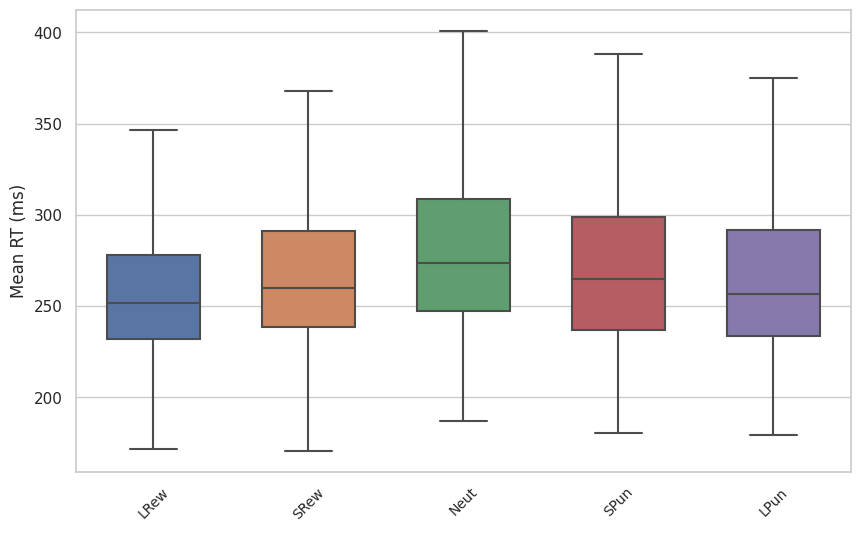

In [13]:
mean_mrt = final_mrt.groupby(['Condition', 'Subject'])['OverallRT'].mean().reset_index()
cue_order = ["LgReward", "SmallReward", "Triangle", "SmallPun", "LgPun"]
renamed_cues = ["LRew","SRew","Neut","SPun","LPun"] # consistent with text in paper/contrasts

sns.set(style="whitegrid")  
plt.figure(figsize=(10, 6))  
sns.boxplot(x="Condition", y="OverallRT", order=cue_order, data=mean_mrt, showfliers=False, width=0.6)
plt.xlabel(" ")
plt.xticks(ticks=range(len(cue_order)),labels=renamed_cues, 
           rotation=45, fontsize=10)  
plt.ylabel("Mean RT (ms)")
plt.show()

In [131]:
fbmrt_out = round(final_mrt.groupby(['Feedback.Response'])['OverallRT'].agg(['mean','std']),2)
round(final_mrt.groupby(['Run','Feedback.Response'])['OverallRT'].agg(['mean','std']),2)

mean     std
Run Feedback.Response                
1   LgPun_hit          240.47   31.27
    LgPun_miss         309.33   89.06
    LgReward_hit       239.66   30.46
    LgReward_miss      298.87  107.58
    SmallPun_hit       241.28   31.89
    SmallPun_miss      321.94  109.34
    SmallReward_hit    242.72   31.91
    SmallReward_miss   311.09   96.02
    Triangle_hit       245.44   33.47
    Triangle_miss      331.65  135.34
2   LgPun_hit          242.85   36.91
    LgPun_miss         323.35  102.60
    LgReward_hit       242.72   36.25
    LgReward_miss      318.21  129.93
    SmallPun_hit       245.15   37.80
    SmallPun_miss      333.05  101.84
    SmallReward_hit    245.72   37.48
    SmallReward_miss   322.75  107.59
    Triangle_hit       246.88   38.15
    Triangle_miss      343.62  107.97

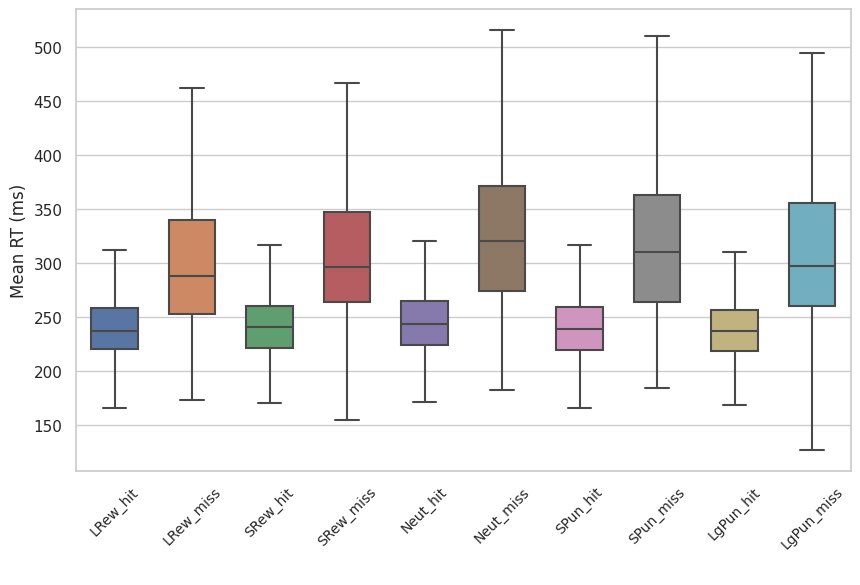

In [15]:
fb_mean_mrt = final_mrt.groupby(['Feedback.Response', 'Subject'])['OverallRT'].mean().reset_index()
fb_order = ["LgReward_hit", "LgReward_miss", "SmallReward_hit", "SmallReward_miss",
            "Triangle_hit","Triangle_miss", "SmallPun_hit", "SmallPun_miss", "LgPun_hit", "LgPun_miss"]
fb_relab = ["LRew_hit", "LRew_miss", "SRew_hit", "SRew_miss",
            "Neut_hit","Neut_miss", "SPun_hit", "SPun_miss", "LgPun_hit", "LgPun_miss"]

sns.set(style="whitegrid")  # Set the style for the plots
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(x="Feedback.Response", y="OverallRT", order=fb_order, data=fb_mean_mrt, showfliers=False, width=0.6)
plt.xlabel(" ")
plt.xticks(ticks=range(len(fb_order)),labels=fb_relab, 
           rotation=45, fontsize=10)  
plt.ylabel("Mean RT (ms)")
plt.show()

### 6.2.1 Accuracy overall and across conditions

In [147]:
acc_out = round(final_acc.groupby(['Condition'])['prbacc'].agg(['mean','std']),2)
round(final_acc.groupby(['Run','Condition'])['prbacc'].agg(['mean','std']),2)

mean   std
Run Condition              
1   LgPun        0.60  0.14
    LgReward     0.64  0.13
    SmallPun     0.57  0.13
    SmallReward  0.58  0.13
    Triangle     0.49  0.18
2   LgPun        0.61  0.15
    LgReward     0.63  0.14
    SmallPun     0.55  0.14
    SmallReward  0.56  0.14
    Triangle     0.45  0.18

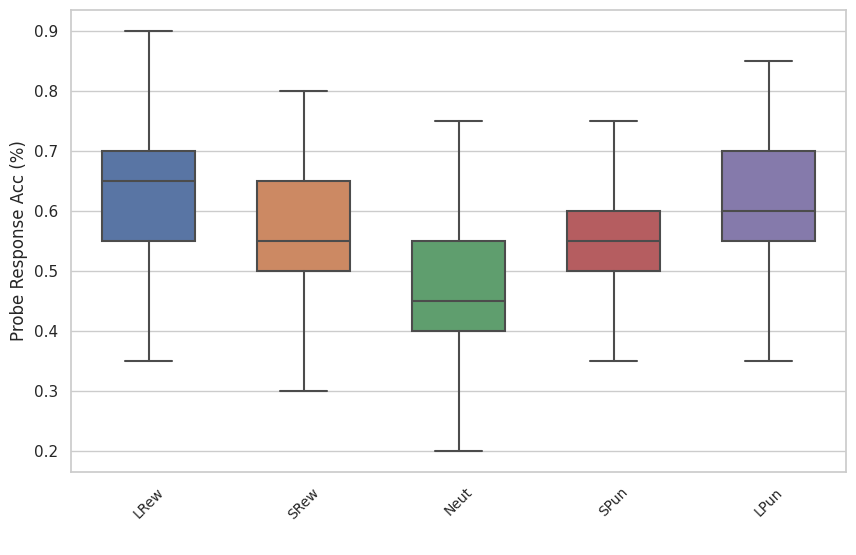

In [17]:
mean_prbacc = final_acc.groupby(['Condition', 'Subject'])['prbacc'].mean().reset_index()
cue_order = ["LgReward", "SmallReward", "Triangle", "SmallPun", "LgPun"]
renamed_cues = ["LRew","SRew","Neut","SPun","LPun"] # consistent with text in paper/contrasts


sns.set(style="whitegrid")  
plt.figure(figsize=(10, 6)) 

sns.boxplot(x="Condition", y="prbacc", order=cue_order, data=mean_prbacc, showfliers=False, width=0.6)
plt.xlabel(" ")
plt.xticks(ticks=range(len(cue_order)),labels=renamed_cues, 
           rotation=45, fontsize=10) 
plt.ylabel("Probe Response Acc (%)")
plt.show()

In [130]:
round(final_acc.groupby(['Run','Feedback.Response'])['prbacc'].agg(['mean','std']),2)

mean  std
Run Feedback.Response           
1   LgPun_hit           1.0  0.0
    LgPun_miss          0.0  0.0
    LgReward_hit        1.0  0.0
    LgReward_miss       0.0  0.0
    SmallPun_hit        1.0  0.0
    SmallPun_miss       0.0  0.0
    SmallReward_hit     1.0  0.0
    SmallReward_miss    0.0  0.0
    Triangle_hit        1.0  0.0
    Triangle_miss       0.0  0.0
2   LgPun_hit           1.0  0.0
    LgPun_miss          0.0  0.0
    LgReward_hit        1.0  0.0
    LgReward_miss       0.0  0.0
    SmallPun_hit        1.0  0.0
    SmallPun_miss       0.0  0.0
    SmallReward_hit     1.0  0.0
    SmallReward_miss    0.0  0.0
    Triangle_hit        1.0  0.0
    Triangle_miss       0.0  0.0

## 6.3.1 `Cue Condition`: Acc / MRT Effect Sizes

In [152]:
results = []

conditions = cue_order
comb_pairs = list(combinations(conditions, 2))

for pair_comp in comb_pairs:
    acc_mean1 = acc_out.loc[pair_comp[0]]['mean']
    acc_std1 = acc_out.loc[pair_comp[0]]['std']
    acc_mean2 = acc_out.loc[pair_comp[1]]['mean']
    acc_std2 = acc_out.loc[pair_comp[1]]['std']

    acc_deffect = round(cohens_d(acc_mean1, acc_std1, acc_mean2, acc_std2, n), 2)

    mrt_mean1 = mrt_out.loc[pair_comp[0]]['mean']
    mrt_std1 = mrt_out.loc[pair_comp[0]]['std']
    mrt_mean2 = mrt_out.loc[pair_comp[1]]['mean']
    mrt_std2 = mrt_out.loc[pair_comp[1]]['std']

    mrt_deffect = round(cohens_d(mrt_mean1, mrt_std1, mrt_mean2, mrt_std2, n), 2)
    
    # Append the results to the list
    results.append({
        'a_condition': pair_comp[0],
        'b_condition': pair_comp[1],
        'acc_mean.a': acc_mean1,
        'acc_mean.b': acc_mean2,
        'acc_std.a': acc_std1,
        'acc_std.b': acc_std2,
        'acc_cohensd': acc_deffect,
        'mrt_mean.a': mrt_mean1,
        'mrt_mean.b': mrt_mean2,
        'mrt_std.a': mrt_std1,
        'mrt_std.b': mrt_std2,
        'mrt_cohensd': mrt_deffect
    })

cuecond_cohensd = pd.DataFrame(results)

In [153]:
cuecond_cohensd

a_condition  b_condition  acc_mean.a  acc_mean.b  acc_std.a  acc_std.b  \
0     LgReward  SmallReward        0.64        0.57       0.13       0.13   
1     LgReward     Triangle        0.64        0.47       0.13       0.18   
2     LgReward     SmallPun        0.64        0.56       0.13       0.14   
3     LgReward        LgPun        0.64        0.60       0.13       0.15   
4  SmallReward     Triangle        0.57        0.47       0.13       0.18   
5  SmallReward     SmallPun        0.57        0.56       0.13       0.14   
6  SmallReward        LgPun        0.57        0.60       0.13       0.15   
7     Triangle     SmallPun        0.47        0.56       0.18       0.14   
8     Triangle        LgPun        0.47        0.60       0.18       0.15   
9     SmallPun        LgPun        0.56        0.60       0.14       0.15   

   acc_cohensd  mrt_mean.a  mrt_mean.b  mrt_std.a  mrt_std.b  mrt_cohensd  
0         0.54      259.82      268.87      47.44      53.27        -0.18  
1         1.08      259.82      283.60      47.44      60.41        -0.44  
2         0.59      259.82      274.52      47.44      57.60        -0.28  
3         0.28      259.82      266.20      47.44      52.14        -0.13  
4         0.64      268.87      283.60      53.27      60.41        -0.26  
5         0.07      268.87      274.52      53.27      57.60        -0.10  
6        -0.21      268.87      266.20      53.27      52.14         0.05  
7        -0.56      283.60      274.52      60.41      57.60         0.15  
8        -0.78      283.60      266.20      60.41      52.14         0.31  
9        -0.28      274.52      266.20      57.60      52.14         0.15

## 6.3.2 `Feedback Condition`: Acc / MRT Effect Sizes

In [154]:
results = []

conditions = ["LgReward_hit", "LgReward_miss","Triangle_hit","Triangle_miss", "LgPun_hit", "LgPun_miss"]
comb_pairs = list(combinations(conditions, 2))

for pair_comp in comb_pairs:
    mrt_mean1 = fbmrt_out.loc[pair_comp[0]]['mean']
    mrt_std1 = fbmrt_out.loc[pair_comp[0]]['std']
    mrt_mean2 = fbmrt_out.loc[pair_comp[1]]['mean']
    mrt_std2 = fbmrt_out.loc[pair_comp[1]]['std']

    mrt_deffect = round(cohens_d(mrt_mean1, mrt_std1, mrt_mean2, mrt_std2, n), 2)
    
    # Append the results to the list
    results.append({
        'a_condition': pair_comp[0],
        'b_condition': pair_comp[1],
        'mrt_mean.a': mrt_mean1,
        'mrt_mean.b': mrt_mean2,
        'mrt_std.a': mrt_std1,
        'mrt_std.b': mrt_std2,
        'mrt_cohensd': mrt_deffect
    })

fdcond_cohensd = pd.DataFrame(results)

In [155]:
fdcond_cohensd

a_condition    b_condition  mrt_mean.a  mrt_mean.b  mrt_std.a  \
0    LgReward_hit  LgReward_miss      241.19      308.59      33.50   
1    LgReward_hit   Triangle_hit      241.19      246.16      33.50   
2    LgReward_hit  Triangle_miss      241.19      337.66      33.50   
3    LgReward_hit      LgPun_hit      241.19      241.66      33.50   
4    LgReward_hit     LgPun_miss      241.19      316.31      33.50   
5   LgReward_miss   Triangle_hit      308.59      246.16     119.67   
6   LgReward_miss  Triangle_miss      308.59      337.66     119.67   
7   LgReward_miss      LgPun_hit      308.59      241.66     119.67   
8   LgReward_miss     LgPun_miss      308.59      316.31     119.67   
9    Triangle_hit  Triangle_miss      246.16      337.66      35.87   
10   Triangle_hit      LgPun_hit      246.16      241.66      35.87   
11   Triangle_hit     LgPun_miss      246.16      316.31      35.87   
12  Triangle_miss      LgPun_hit      337.66      241.66     122.45   
13  Triangle_miss     LgPun_miss      337.66      316.31     122.45   
14      LgPun_hit     LgPun_miss      241.66      316.31      34.21   

    mrt_std.b  mrt_cohensd  
0      119.67        -0.77  
1       35.87        -0.14  
2      122.45        -1.07  
3       34.21        -0.01  
4       96.25        -1.04  
5       35.87         0.71  
6      122.45        -0.24  
7       34.21         0.76  
8       96.25        -0.07  
9      122.45        -1.01  
10      34.21         0.13  
11      96.25        -0.97  
12      34.21         1.07  
13      96.25         0.19  
14      96.25        -1.03

# 7. Test group model randomise


Below is an example run of [FSL's randomise](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Randomise/UserGuide). For testing purposes, we only use 100 permutations here. In the final models, we use [1000 permutations](https://github.com/demidenm/mid_rt_bold/blob/main/scripts/model_designmat_regressors.py#L276C1-L276C64)

In [51]:
def make_randomise_files(desmat_final, regressor_names, contrasts, outdir):
    '''
    desmat_final: numpy array of the design matrix
    regressor_names: The regressor names that correspond to the columns of desmat_final
      note, the contrasts are defined using these names.  e.g. ['intercept', 'rt_centered']
    contrasts: expression_to_contrast is used, so these are entered as a list of
      string-based contrast definitions that use regressor_names: [['intercept'], ['rt_centered']]
    outdir: where you're saving all of the files
    '''
    import numpy as np
    from nilearn.glm.contrasts import expression_to_contrast_vector
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        
    num_input_contrasts = desmat_final.shape[0]
    num_regressors = desmat_final.shape[1]
    # make the desmat.mat file (fsl header with design matrix below)
    # First just make the file header and then append the desmat data
    desmat_path = f'{outdir}/desmat.mat'
    with open(desmat_path, 'w') as f:
        f.write(f'/NumWaves	{num_regressors} \n/NumPoints {num_input_contrasts} '
                '\n/PPheights 1.000000e+00 \n \n/Matrix \n')
        np.savetxt(f, desmat_final, delimiter='\t')
    # .grp file (required for f-tests)
    grp_path = f'{outdir}/desmat.grp' 
    with open(grp_path, 'w') as f:
        f.write(f'/NumWaves  1 \n/NumPoints {num_input_contrasts}\n \n/Matrix \n')
        np.savetxt(f, np.ones(num_input_contrasts), fmt='%s', delimiter='\t') 
    # save out contrasts in .con file
    contrast_matrix = []
    num_contrasts = len(contrasts)
    for contrast in contrasts:
        contrast_def = expression_to_contrast_vector(
            contrast[0], regressor_names)
        contrast_matrix.append(np.array(contrast_def))
    con_path = f'{outdir}/desmat.con' 
    ppheight_and_reqeff = '\t '.join(str(val) for val in [1]*num_contrasts) 
    with open(con_path, 'w') as f:
        for val, contrast in enumerate(contrasts):
            f.write(f'/ContrastName{val+1} {contrast[0]}\n')
        f.write(f'/NumWaves  {num_regressors} \n/NumContrasts {num_contrasts}'
                f'\n/PPheights {ppheight_and_reqeff} ' 
                f'\n/RequiredEffect {ppheight_and_reqeff} \n \n/Matrix \n')
        np.savetxt(f, contrast_matrix, delimiter='\t') 
    # fts file (used for f-test)
    fts_path = f'{outdir}/desmat.fts' 
    with open(fts_path, 'w') as f:
        f.write(f'/NumWaves  {num_contrasts} \n/NumContrasts {num_contrasts}\n \n/Matrix \n')
        np.savetxt(f, np.identity(num_contrasts), fmt='%s', delimiter='\t') 


def make_randomise_rt(comb_nii_path, outdir, permutations=100):
    '''
    This hasn't been tested at all, since I launched this differently on Sherlock
    filename_input_root:  this is the filename used to make the mask and data file.  They should
    have the same names, but the mask file ends in _mask.  See the code below to clarify and edit accordingly.
    outdir: same output directoroy where the files from make_randomise_files were saved to

    '''
    from pathlib import Path
    import stat
    
    inp_dir, file_name = os.path.split(comb_nii_path)
    file_noext, _ = os.path.splitext(file_name)
    if not os.path.exists(f'{outdir}'):
        os.makedirs(f'{outdir}')
        
    randomise_call = (f'randomise -i {inp_dir}/{file_name}'
                f' -o {outdir}/{file_noext}_randomise'
                f' -m {inp_dir}/{file_noext}_mask.nii.gz'
                f' -d {outdir}/desmat.mat -t {outdir}/desmat.con' 
                f' -f {outdir}/desmat.fts  -T -n {permutations}')

    randomise_call_file = Path(f'{outdir}/randomise_call.sh')
    with open (randomise_call_file, 'w') as f:
        f.write(randomise_call)
    # This should change the file permissions to make the script executeable
    randomise_call_file.chmod(randomise_call_file.stat().st_mode | stat.S_IXGRP | stat.S_IEXEC)

def make_randomise_grp(comb_nii_path, outdir, permutations=1000):
    '''
    This hasn't been tested at all, since I launched this differently on Sherlock
    filename_input_root:  this is the filename used to make the mask and data file.  They should
    have the same names, but the mask file ends in _mask.  See the code below to clarify and edit accordingly.
    outdir: same output directoroy where the files from make_randomise_files were saved to

    '''
    from pathlib import Path
    import stat
    
    if not os.path.exists(f'{outdir}'):
        os.makedirs(f'{outdir}')
        
    inp_dir, file_name = os.path.split(comb_nii_path)
    file_noext, _ = os.path.splitext(file_name)
    
    randomise_call = (f'randomise -i {inp_dir}/{file_name}'
                f' -o {outdir}/{file_noext}_randomise'
                f' -m {inp_dir}/{file_noext}_mask.nii.gz'
                f' -1 -t {outdir}/desmat.con' 
                f' -f {outdir}/desmat.fts  -T -n {permutations}')

    randomise_call_file = Path(f'{outdir}/randomise_call.sh')
    with open (randomise_call_file, 'w') as f:
        f.write(randomise_call)
    # This should change the file permissions to make the script executeable
    randomise_call_file.chmod(randomise_call_file.stat().st_mode | stat.S_IXGRP | stat.S_IEXEC)

In [4]:
def make_4d_data_mask(bold_paths,sess,contrast_lab, model_type,tmp_dir):
    from nilearn.maskers import NiftiMasker
    if not os.path.exists(f'{tmp_dir}'):
        os.makedirs(f'{tmp_dir}')
        
    n_maps=len(bold_paths)
    data4d = nib.funcs.concat_images(bold_paths)
    masked_4d = NiftiMasker().fit(data4d).mask_img_
    filename_root = (f'{tmp_dir}/subs-{n_maps}_ses-{sess}_task-MID_contrast-{contrast_lab}_{model_type}')
    data4d.to_filename(f'{filename_root}.nii.gz')
    masked_4d.to_filename(f'{filename_root}_mask.nii.gz') 

In [5]:
session = '2YearFollowUpYArm1'
out_path = '/scratch.global/mdemiden/mid_rt_mod'
grpmap_path = f'{out_path}/group/ses-{session}/session'
fix_path = f'{out_path}/firstlvl/ses-{session}'
tmp_path = '/home/feczk001/mdemiden/analyses/tmp'

In [20]:
contrast='ARewHit-ARewMiss'
model='mod-Cue-None'
list_maps = sorted(glob(f'{fix_path}/**/*_ses-{session}_task-MID_contrast-{contrast}_{model}_stat-effect.nii.gz'))
sub_rt_df = pd.read_csv(f'{out_path}/subs_avg-overall-rts.csv', sep=',')

In [58]:
make_4d_data_mask(bold_paths=list_maps,sess=session,contrast_lab=contrast, model_type=model,tmp_dir=tmp_path)

In [21]:
sub_ids = [os.path.basename(path).split('_')[0] for path in list_maps]
subset_df = sub_rt_df[sub_rt_df['Subject'].isin(sub_ids)].copy()
subset_df = subset_df.set_index('Subject').loc[sub_ids].reset_index() # ensure index sorts same as IDs
assert (subset_df['Subject'].values ==
        np.array(sub_ids)).all(), "Order of IDs in subset_df != sub_ids."

mean_rt = subset_df['Average_RT'].mean()
subset_df['Mean_Centered_RT'] = (subset_df['Average_RT'] - mean_rt).values
rt_vals = subset_df['Mean_Centered_RT'].values

In [59]:
N_maps = len(list_maps)
comb_input_nii = f'{tmp_path}/subs-500_ses-{session}_task-MID_contrast-{contrast}_{model}.nii'
contrast='ARewHit-ARewMiss'

for level in ['grp','rt']:
    if level == 'grp':
        # Create design matrix with intercept (1s) that's length of subjects/length of fixed_files
        design_matrix = pd.DataFrame({'int': [1] * N_maps})
        make_randomise_files(desmat_final=design_matrix, regressor_names='int', 
                             contrasts=['int'], outdir=f'{tmp_path}/randomise/{contrast}/{level}')
        make_randomise_grp(comb_nii_path=comb_input_nii, outdir=f'{tmp_path}/randomise/{contrast}/{level}')

    else:
        design_matrix = pd.DataFrame({'int': [1] * N_maps, 'rt': rt_vals})
        make_randomise_files(desmat_final=design_matrix, regressor_names=['int','rt'],  
                             contrasts=[['rt']], outdir=f'{tmp_path}/randomise/{contrast}/{level}')
        make_randomise_rt(comb_nii_path=comb_input_nii, outdir=f'{tmp_path}/randomise/{contrast}/{level}')

    
    

In [ ]:
import subprocess
for level in ['grp','rt']:
    print("*** Running: *** ", level)
    script_path = f'{tmp_path}/randomise/{contrast}/{level}/randomise_call.sh'
    subprocess.run(['bash',script_path])